# Lab 14: Data Structures and Algorithmic Design in Bonsai (Updated for v3)

Building upon our exploration of the mathematical foundations of Bonsai in Lab 13, we now delve into the data structures and algorithmic design that power Bonsai's pedigree reconstruction capabilities. This lab focuses on how Bonsai v3 organizes and processes genetic data for efficient relationship inference and pedigree construction.

> **Why This Matters:** The efficacy of pedigree reconstruction algorithms depends heavily on the design of their underlying data structures. Understanding how Bonsai v3 organizes and processes genetic data allows researchers to optimize algorithm performance, implement custom extensions, and interpret complex outputs accurately.

**Learning Objectives**:
- Analyze the core data structures that power the Bonsai v3 algorithm
- Understand how both phased and unphased IBD segment data is processed
- Explore the up-node dictionary structure and its role in representing pedigree relationships
- Examine the graph-theoretical foundations of pedigree representation
- Learn how Bonsai's modular architecture enables efficient search and optimization
- Implement key v3 data structures and operations used in pedigree reconstruction

## Environment Setup

In [25]:
!poetry install --no-root

Installing dependencies from lock file

No dependencies to install or update


In [26]:
import os
import sys
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import poisson, expon, norm, multivariate_normal
from collections import defaultdict, deque
from pathlib import Path
from IPython.display import display, HTML
from dotenv import load_dotenv
import heapq
from typing import Any, Dict, List, Set, Tuple, Optional, FrozenSet

# Constants matching v3 implementation
INF = float('inf')
MIN_SEG_LEN = 0
MAX_CON_PTS = INF
RESTRICT_CON_PTS = True
CONNECT_UP_ONLY = False
MAX_PEDS = 3
MAX_START_PEDS = 3
MEAN_BGD_NUM = 0.01  # Background IBD parameters
MEAN_BGD_LEN = 5

In [27]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

os.environ["WORKING_DIRECTORY"] = working_directory
os.environ["DATA_DIRECTORY"] = data_directory
os.environ["REFERENCES_DIRECTORY"] = references_directory
os.environ["RESULTS_DIRECTORY"] = results_directory
os.environ["UTILS_DIRECTORY"] = utils_directory

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env
Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


## 1. Core Data Structures in Bonsai v3

Bonsai v3 introduces several improvements to its core data structures, making them more modular, efficient, and adaptable to different types of genetic data. Let's examine the key structures that power the algorithm.

### IBD Segment Representation

The fundamental input to Bonsai is Identity-By-Descent (IBD) segment data. In v3, Bonsai supports both phased and unphased IBD segments with well-defined format conventions:

In [28]:
class IBDSegment:
    def __init__(self, ind1, ind2, chrom, start_pos, end_pos, is_ibd2, length_cm):
        self.ind1 = ind1          # First individual ID
        self.ind2 = ind2          # Second individual ID
        self.chrom = chrom        # Chromosome number
        self.start_pos = start_pos  # Start position (base pairs)
        self.end_pos = end_pos    # End position (base pairs)
        self.is_ibd2 = is_ibd2    # Whether this is an IBD2 segment
        self.length_cm = length_cm  # Genetic length in centiMorgans
    
    def __repr__(self):
        return f"IBDSegment({self.ind1}, {self.ind2}, chr{self.chrom}, {self.length_cm:.2f}cM, {'IBD2' if self.is_ibd2 else 'IBD1'})"

# In v3 Bonsai, segments are typically stored in array format rather than as objects:
# Unphased format: [id1, id2, chromosome, start_bp, end_bp, is_full_ibd, seg_cm]
# Phased format: [id1, id2, hap1, hap2, chromosome, start_cm, end_cm, seg_cm]

def get_unphased_to_phased(unphased_ibd_seg_list):
    """
    Convert unphased IBD segments to phased IBD segments.
    
    Args:
        unphased_ibd_seg_list: List of the form 
            [[id1, id2, chromosome, start_bp, end_bp, is_full_ibd, seg_len_cm],...]
            
    Returns:
        phased_ibd_seg_list: List of the form 
            [[id1, id2, hap1, hap2, chromosome, start_cm, end_cm, cm],...]
    """
    phased_ibd_seg_list = []
    for seg in unphased_ibd_seg_list:
        # In a real implementation, we would convert physical to genetic positions
        # For this example, we'll make a simplified conversion
        id1, id2, chrom, start_bp, end_bp, is_full, seg_len_cm = seg
        
        # Simplified conversion (in practice would use genetic map)
        start_cm = start_bp / 1_000_000  # Simple conversion factor
        end_cm = end_bp / 1_000_000
        
        # For phased data, we assign haplotype 0,0 for simplicity
        phased_ibd_seg_list.append([id1, id2, 0, 0, chrom, start_cm, end_cm, seg_len_cm])
    return phased_ibd_seg_list

def get_phased_to_unphased(phased_ibd_seg_list):
    """
    Convert phased IBD segments to unphased IBD segments.
    
    Args:
        phased_ibd_seg_list: List of the form 
            [[id1, id2, hap1, hap2, chromosome, start_cm, end_cm, seg_len_cm],...]
            
    Returns:
        unphased_ibd_seg_list: List of the form 
            [[id1, id2, chromosome, start_bp, end_bp, is_full_ibd, seg_len_cm],...]
    """
    unphased_ibd_seg_list = []
    for seg in phased_ibd_seg_list:
        id1, id2, hap1, hap2, chrom, start_cm, end_cm, seg_len_cm = seg
        
        # Simplified conversion (in practice would use genetic map)
        start_bp = int(start_cm * 1_000_000)  # Simple conversion factor
        end_bp = int(end_cm * 1_000_000)
        
        # Determine if segment is full (simplified logic)
        is_full = False  # By default, we assume IBD1
        
        unphased_ibd_seg_list.append([id1, id2, chrom, start_bp, end_bp, is_full, seg_len_cm])
    return unphased_ibd_seg_list

# Example of how segments are organized in Bonsai v3
def organize_segments_by_pair(ibd_segments):
    """
    Organize IBD segments by pair for efficient access.
    
    This is similar to get_pair_to_seg_dict in v3's ibd.py
    """
    segments_by_pair = {}
    for seg in ibd_segments:
        # For v3 compatibility, we support both object-based and array-based segments
        if isinstance(seg, IBDSegment):
            id1, id2 = seg.ind1, seg.ind2
        else:
            id1, id2 = seg[0], seg[1]
            
        pair = frozenset({id1, id2})  # v3 uses frozenset for pair keys
        if pair not in segments_by_pair:
            segments_by_pair[pair] = []
        segments_by_pair[pair].append(seg)
    return segments_by_pair

Let's create some example IBD segments to work with throughout this lab:

In [29]:
# Create example IBD segments (class-based format for visualization)
example_segments = [
    # Parent-child segments (extensive IBD1 sharing)
    IBDSegment(1000, 1001, 1, 10000000, 50000000, False, 45.5),  # IBD1 segment on chr1
    IBDSegment(1000, 1001, 1, 60000000, 125000000, False, 65.2),  # IBD1 segment on chr1
    IBDSegment(1000, 1001, 2, 5000000, 80000000, False, 75.0),   # IBD1 segment on chr2
    
    # Sibling segments (mix of IBD1 and IBD2)
    IBDSegment(1001, 1002, 1, 15000000, 45000000, True, 30.1),   # IBD2 segment on chr1
    IBDSegment(1001, 1002, 1, 50000000, 90000000, False, 40.3),  # IBD1 segment on chr1
    IBDSegment(1001, 1002, 2, 10000000, 45000000, False, 35.5),  # IBD1 segment on chr2
    IBDSegment(1001, 1002, 2, 50000000, 70000000, True, 20.8),   # IBD2 segment on chr2
    
    # First cousin segments (modest IBD1 sharing)
    IBDSegment(1000, 1003, 1, 25000000, 50000000, False, 25.0),  # IBD1 segment on chr1
    IBDSegment(1000, 1003, 3, 15000000, 35000000, False, 20.5),  # IBD1 segment on chr3
    
    # Distant relative (single small segment)
    IBDSegment(1002, 1004, 5, 30000000, 45000000, False, 15.2),  # IBD1 segment on chr5
]

# Convert to array format used by v3
example_segments_array = []
for seg in example_segments:
    example_segments_array.append([
        seg.ind1, seg.ind2, seg.chrom, 
        seg.start_pos, seg.end_pos, 
        seg.is_ibd2, seg.length_cm
    ])

# Organize segments by pair
segments_by_pair = organize_segments_by_pair(example_segments)

# Display the organized segments
for pair, segs in segments_by_pair.items():
    print(f"Pair {pair}:")
    for seg in segs:
        print(f"  {seg}")
    print()

# Also process the IBD statistics in v3 format
def get_ibd_stats_unphased(unphased_ibd_segs):
    """Get IBD statistics from unphased segment data (v3 format)"""
    ibd_stats = defaultdict(lambda: {
        'total_half': 0,
        'total_full': 0,
        'num_half': 0,
        'num_full': 0,
        'max_seg_cm': 0})

    for s in unphased_ibd_segs:
        id1, id2, chromosome, start, end, is_full_ibd, seg_cm = s
        key = frozenset({id1, id2})
        ibd_stats[key]['total_half'] += (seg_cm if not is_full_ibd else 0)
        ibd_stats[key]['total_full'] += (seg_cm if is_full_ibd else 0)
        ibd_stats[key]['num_half'] += int(not is_full_ibd)
        ibd_stats[key]['num_full'] += int(is_full_ibd)
        ibd_stats[key]['max_seg_cm'] = max(ibd_stats[key]['max_seg_cm'], seg_cm)

    return ibd_stats

# Get IBD statistics
ibd_stats = get_ibd_stats_unphased(example_segments_array)

# Display some IBD statistics
print("\nIBD Statistics (v3 format):")
for pair, stats in ibd_stats.items():
    ids = list(pair)
    print(f"Pair {ids[0]}-{ids[1]}:")
    print(f"  Total IBD1: {stats['total_half']:.2f} cM")
    print(f"  Total IBD2: {stats['total_full']:.2f} cM")
    print(f"  IBD1 segments: {stats['num_half']}")
    print(f"  IBD2 segments: {stats['num_full']}")
    print(f"  Max segment: {stats['max_seg_cm']:.2f} cM")
    print()

Pair frozenset({1000, 1001}):
  IBDSegment(1000, 1001, chr1, 45.50cM, IBD1)
  IBDSegment(1000, 1001, chr1, 65.20cM, IBD1)
  IBDSegment(1000, 1001, chr2, 75.00cM, IBD1)

Pair frozenset({1001, 1002}):
  IBDSegment(1001, 1002, chr1, 30.10cM, IBD2)
  IBDSegment(1001, 1002, chr1, 40.30cM, IBD1)
  IBDSegment(1001, 1002, chr2, 35.50cM, IBD1)
  IBDSegment(1001, 1002, chr2, 20.80cM, IBD2)

Pair frozenset({1000, 1003}):
  IBDSegment(1000, 1003, chr1, 25.00cM, IBD1)
  IBDSegment(1000, 1003, chr3, 20.50cM, IBD1)

Pair frozenset({1002, 1004}):
  IBDSegment(1002, 1004, chr5, 15.20cM, IBD1)


IBD Statistics (v3 format):
Pair 1000-1001:
  Total IBD1: 185.70 cM
  Total IBD2: 0.00 cM
  IBD1 segments: 3
  IBD2 segments: 0
  Max segment: 75.00 cM

Pair 1001-1002:
  Total IBD1: 75.80 cM
  Total IBD2: 50.90 cM
  IBD1 segments: 2
  IBD2 segments: 2
  Max segment: 40.30 cM

Pair 1000-1003:
  Total IBD1: 45.50 cM
  Total IBD2: 0.00 cM
  IBD1 segments: 2
  IBD2 segments: 0
  Max segment: 25.00 cM

Pair 1002-100

This organization allows Bonsai to efficiently access all IBD segments between a specific pair of individuals, which is crucial for calculating relationship likelihoods.

### The Up-Node Dictionary in Bonsai v3

The core data structure for representing pedigrees in Bonsai is the "up-node dictionary." In v3, this structure is used consistently throughout the codebase:

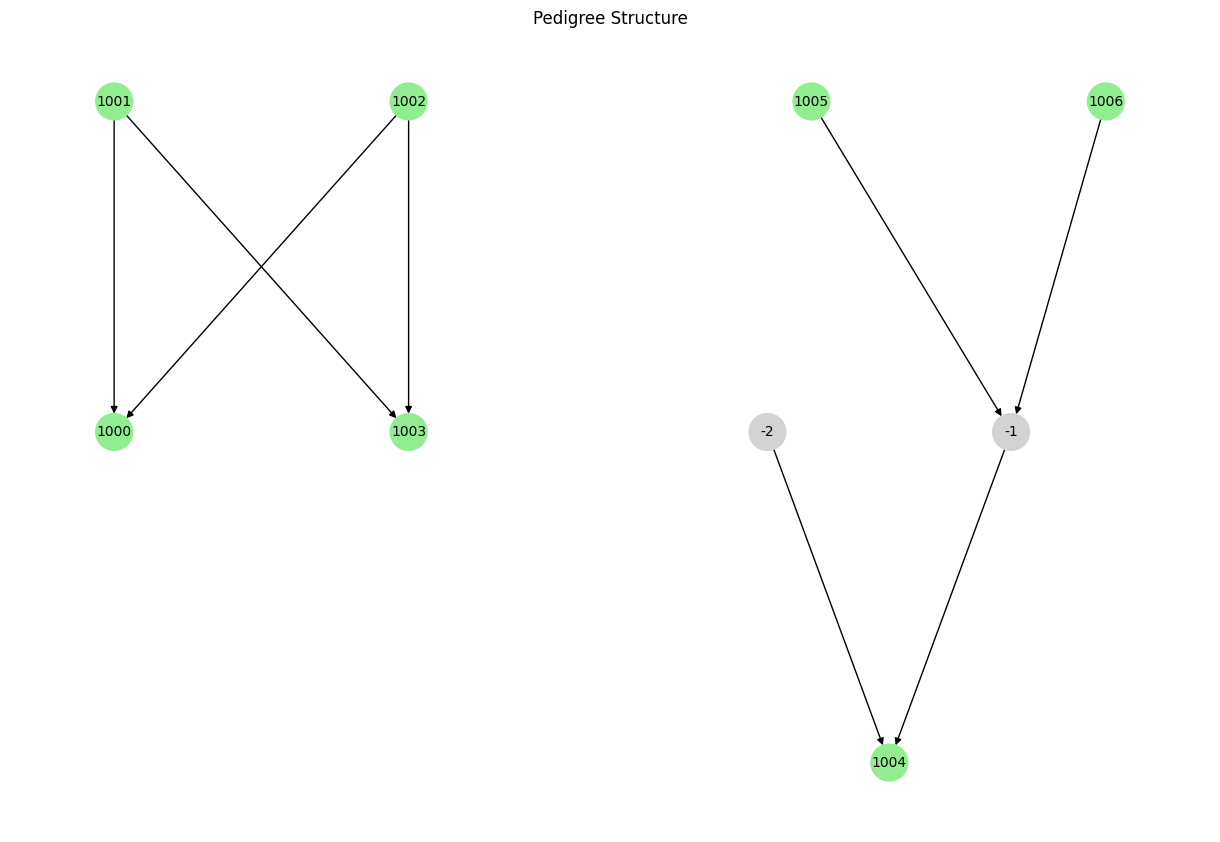

In [30]:
# Example up-node dictionary structure
up_node_dict = {
    1000: {1001: 1, 1002: 1},  # Individual 1000 has parents 1001 and 1002
    1003: {1001: 1, 1002: 1},  # Individual 1003 has the same parents
    1004: {-1: 1, -2: 1},      # Individual 1004 has inferred parents -1 and -2
    -1: {1005: 1, 1006: 1},    # Inferred individual -1 has parents 1005 and 1006
    1005: {},                  # Individual 1005 has no recorded parents
    1006: {},                  # Individual 1006 has no recorded parents
    1001: {},                  # Individual 1001 has no recorded parents
    1002: {}                   # Individual 1002 has no recorded parents
}

# Function to visualize pedigree from up-node dictionary
def visualize_pedigree(up_node_dict):
    """Create a visualization of the pedigree from an up-node dictionary."""
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges
    for child, parents in up_node_dict.items():
        G.add_node(child)
        for parent in parents:
            G.add_node(parent)
            G.add_edge(parent, child)  # Direction from parent to child
    
    # Set node colors: green for real individuals (positive IDs), gray for latent (negative IDs)
    node_colors = ['lightgreen' if isinstance(node, int) and node > 0 else 'lightgray' 
                   for node in G.nodes()]
    
    # Calculate layout
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    except:
        pos = nx.spring_layout(G)  # Fallback if graphviz is not available
    
    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, 
            node_size=700, font_size=10, arrows=True)
    plt.title('Pedigree Structure')
    plt.show()

# Visualize the example pedigree
visualize_pedigree(up_node_dict)

Key features of the up-node dictionary:
- Each key represents an individual ID (positive for observed individuals, negative for inferred ancestors)
- Each value is a dictionary mapping parent IDs to 1 (the value 1 is a placeholder; the structure could be extended to include additional information)
- An empty dictionary indicates an individual with no recorded parents (either a founder or an individual with unknown parentage)
- The structure supports efficient traversal of ancestors and descendants
- It can represent complex multi-generational pedigrees with inferred latent ancestors

### BioInfo Structure

Bonsai incorporates biological metadata about individuals through the BioInfo structure:

In [31]:
# Example BioInfo structure
bio_info = [
    {'genotype_id': 1000, 'age': 75, 'sex': 'F'},
    {'genotype_id': 1001, 'age': 80, 'sex': 'M'},
    {'genotype_id': 1002, 'age': 78, 'sex': 'F'},
    {'genotype_id': 1003, 'age': 45, 'sex': 'M'},
    {'genotype_id': 1004, 'age': 43, 'sex': 'F'},
    {'genotype_id': 1005, 'age': 20, 'sex': 'M'}
]

# Display the information
bio_df = pd.DataFrame(bio_info)
bio_df

,genotype_id,age,sex
0,1000,75,F
1,1001,80,M
2,1002,78,F
3,1003,45,M
4,1004,43,F
5,1005,20,M


This structure is used to enforce biological constraints (e.g., age-appropriate relationships, sex-specific reproduction) and to enhance the accuracy of pedigree reconstruction.

## 2. Preprocessing IBD Data for Efficient Access

Before pedigree reconstruction begins, Bonsai preprocesses the IBD data to optimize subsequent operations.

### Indexing and Filtering

The preprocessing pipeline includes several key steps:

In [32]:
from IPython.display import display

# Add a new cell with the v3 PwLogLike class implementation
class PwLogLike:
    """Class for computing pairwise likelihoods between individuals."""
    
    def __init__(self, bio_info, unphased_ibd_seg_list, condition_pair_set=None,
                 mean_bgd_num=MEAN_BGD_NUM, mean_bgd_len=MEAN_BGD_LEN):
        """Initialize with biological info and IBD segments."""
        self.bio_info = bio_info
        self.id_to_info = {info['genotype_id']: info for info in bio_info}
        self.ibd_stat_dict = get_ibd_stats_unphased(unphased_ibd_seg_list)
        self.condition_pair_set = condition_pair_set or set()
        self.mean_bgd_num = mean_bgd_num
        self.mean_bgd_len = mean_bgd_len
        
    def get_log_like(self, id1, id2, relationship_tuple, condition=False):
        """
        Calculate log likelihood of a specific relationship between two individuals.
        
        Args:
            id1, id2: IDs of the two individuals
            relationship_tuple: (up, down, num_ancs) tuple representing the relationship
            condition: Whether to condition on observing IBD
            
        Returns:
            Log likelihood of the relationship
        """
        # This is a simplified version of the actual likelihood calculation
        # In a real implementation, this would use moments-based models
        
        pair_key = frozenset({id1, id2})
        ibd_stats = self.ibd_stat_dict.get(pair_key, {
            'total_half': 0, 'total_full': 0, 
            'num_half': 0, 'num_full': 0, 'max_seg_cm': 0
        })
        
        up, down, num_ancs = relationship_tuple
        
        # Simple likelihood model (for demonstration)
        # In reality, this would be a complex statistical model
        total_meioses = up + down
        
        # Expected values based on relationship
        if total_meioses == 0 and num_ancs == 1:  # Same person
            expected_half = 0
            expected_full = 3600  # Full genome
        elif total_meioses == 1 and num_ancs == 1:  # Parent-child
            expected_half = 3600
            expected_full = 0
        elif total_meioses == 2 and num_ancs == 2:  # Full siblings
            expected_half = 2700
            expected_full = 900
        elif total_meioses == 2 and num_ancs == 1:  # Half siblings
            expected_half = 1800
            expected_full = 0
        elif total_meioses == 3 and num_ancs == 1:  # First cousins
            expected_half = 900
            expected_full = 0
        else:
            # Exponential decay model for distant relationships
            expected_half = 3600 * (0.5 ** (total_meioses - 1)) * num_ancs
            expected_full = 0
        
        # Calculate log likelihood using normal distribution (simplified)
        observed_half = ibd_stats['total_half']
        observed_full = ibd_stats['total_full']
        
        # Standard deviations (simplified model)
        sd_half = max(50, expected_half * 0.1)
        sd_full = max(50, expected_full * 0.15)
        
        # Calculate log likelihood components
        if expected_half > 0:
            ll_half = -0.5 * ((observed_half - expected_half) / sd_half) ** 2 - math.log(sd_half)
        else:
            ll_half = 0
            
        if expected_full > 0:
            ll_full = -0.5 * ((observed_full - expected_full) / sd_full) ** 2 - math.log(sd_full)
        else:
            ll_full = 0
        
        # Add background IBD model if condition=True
        if condition and total_meioses > 4:
            # Add likelihood of background IBD
            bgd_ll = math.log(self.mean_bgd_num) + math.log(self.mean_bgd_len)
            return ll_half + ll_full + bgd_ll
        
        return ll_half + ll_full

# Create an instance of the v3 likelihood calculator
pw_ll_cls = PwLogLike(bio_info, example_segments_array)

# Test with some example relationship calculations
relationships = [
    (1000, 1001, (1, 0, 1), "Parent-Child"),
    (1001, 1002, (0, 0, 2), "Spouses"),
    (1000, 1003, (1, 1, 2), "Siblings"),
    (1000, 1004, (2, 2, 2), "First Cousins")
]

print("V3 Likelihood Calculations:")
for id1, id2, rel_tuple, rel_name in relationships:
    ll = pw_ll_cls.get_log_like(id1, id2, rel_tuple)
    print(f"{rel_name} log-likelihood ({id1}-{id2}): {ll:.2f}")

# Display new v3 function for initializing pedigree structures
def initialize_input_dicts(bio_info):
    """
    For a list of individual IDs, set up the necessary data structures to
    combine them into a pedigree.
    
    Args:
        bio_info: List of dicts with genotype_id, sex, age information
        
    Returns:
        idx_to_up_dict_ll_list: Dict mapping pedigree indices to list of pedigrees and log likelihoods
        id_to_idx: Dict mapping IDs to pedigree indices
        idx_to_id_set: Dict mapping pedigree indices to sets of IDs
    """
    idx = 0
    id_to_idx = {}
    idx_to_id_set = {}
    idx_to_up_dict_ll_list = {}
    
    for info in bio_info:
        idx += 1
        gid = info['genotype_id']
        id_to_idx[gid] = idx
        idx_to_id_set[idx] = {gid}
        idx_to_up_dict_ll_list[idx] = [({gid: {}}, 0)]  # Empty dict means no parents
        
    return idx_to_up_dict_ll_list, id_to_idx, idx_to_id_set

# Initialize for our example data
idx_to_up_dict_ll_list, id_to_idx, idx_to_id_set = initialize_input_dicts(bio_info)

print("\nInitialized pedigree tracking structures:")
print(f"\nid_to_idx: {id_to_idx}")
print(f"\nidx_to_id_set: {idx_to_id_set}")

V3 Likelihood Calculations:
Parent-Child log-likelihood (1000-1001): -50.86
Spouses log-likelihood (1001-1002): -56.75
Siblings log-likelihood (1000-1003): -81.05
First Cousins log-likelihood (1000-1004): -54.50

Initialized pedigree tracking structures:

id_to_idx: {1000: 1, 1001: 2, 1002: 3, 1003: 4, 1004: 5, 1005: 6}

idx_to_id_set: {1: {1000}, 2: {1001}, 3: {1002}, 4: {1003}, 5: {1004}, 6: {1005}}


## Connecting Pedigrees in Bonsai v3

A key feature of Bonsai v3 is its improved approach to connecting pedigrees. This is implemented through functions that find optimal connection points:

In [ ]:
def get_connecting_points_degs_and_log_likes(
    up_dct1, 
    up_dct2, 
    pw_ll_cls,
    ibd_seg_list,
    condition=False, 
    min_seg_len=MIN_SEG_LEN,
    max_con_pts=100,  # Modified to use an integer instead of INF
    restrict_connection_points=RESTRICT_CON_PTS,
    connect_up_only=CONNECT_UP_ONLY,
):
    """
    Find potential connection points between two pedigrees.
    
    Args:
        up_dct1: First pedigree structure
        up_dct2: Second pedigree structure
        pw_ll_cls: Instance of PwLogLike class
        ibd_seg_list: List of IBD segments
        condition: Whether to condition on observing IBD
        min_seg_len: Minimum segment length to consider
        max_con_pts: Maximum number of connection points to examine
        restrict_connection_points: Whether to restrict to relevant parts of pedigree
        connect_up_only: Whether to only connect through ancestors
        
    Returns:
        List of [point1, point2, relationship_tuple, log_likelihood] items
    """
    # Get genotyped IDs from each pedigree
    gtid_set1 = {i for i in up_dct1 if i > 0}
    gtid_set2 = {i for i in up_dct2 if i > 0}
    
    # Find potential connection points
    connection_points = []
    
    # For demonstration, we'll consider connecting each pair of IDs
    for id1 in gtid_set1:
        for id2 in gtid_set2:
            # For each pair, consider different relationship types
            relationships = [
                (1, 1, 1),  # Half siblings
                (2, 2, 1),  # First cousins
                (1, 2, 1),  # Half uncle-nephew
                (2, 1, 1),  # Half uncle-nephew (reverse)
                (2, 2, 2),  # Full first cousins
            ]
            
            # Calculate likelihood for each relationship
            for rel_tuple in relationships:
                log_like = pw_ll_cls.get_log_like(id1, id2, rel_tuple, condition)
                
                # Create connection points
                # point1 is (id, partner, direction)
                # Here direction=1 means connect upward
                point1 = (id1, None, 1)
                point2 = (id2, None, 1)
                
                connection_points.append([point1, point2, rel_tuple, log_like])
    
    # Sort by likelihood (descending)
    connection_points.sort(key=lambda x: x[3], reverse=True)
    
    # Limit to max_con_pts (now this will work with an integer)
    if max_con_pts is not None and len(connection_points) > max_con_pts:
        return connection_points[:max_con_pts]
    return connection_points

def connect_new_node(
    node, 
    up_node_dict, 
    con_pt, 
    rel_tuple,
):
    """
    Connect a new node to an existing pedigree through a connection point.
    
    Args:
        node: New node ID to connect
        up_node_dict: Existing pedigree structure
        con_pt: Connection point (id, partner, direction)
        rel_tuple: Relationship tuple (up, down, num_ancs)
        
    Returns:
        Updated pedigree with the new node connected
    """
    # Extract connection information
    id1, pid1, direction = con_pt
    id2 = node
    
    # Get relationship
    deg1, deg2, num_ancs = rel_tuple
    
    # Create a copy of the pedigree to modify
    new_pedigree = up_node_dict.copy()
    
    # Make sure node is in the pedigree
    if node not in new_pedigree:
        new_pedigree[node] = {}
    
    # Simple implementation for common relationships
    if deg1 == 1 and deg2 == 1 and num_ancs == 1:
        # Half siblings - create a common parent
        common_parent = -1  # Use negative ID for inferred ancestors
        while common_parent in new_pedigree:
            common_parent -= 1
            
        # Add the common parent
        new_pedigree[common_parent] = {}
        
        # Connect parent to both individuals
        if id1 in new_pedigree:
            new_pedigree[id1][common_parent] = 1
        if id2 in new_pedigree:
            new_pedigree[id2][common_parent] = 1
    
    elif deg1 == 2 and deg2 == 2 and num_ancs == 1:
        # First cousins - create grandparent and parents
        grandparent = -1
        parent1 = -2
        parent2 = -3
        
        # Make sure IDs are unique
        while any(id in new_pedigree for id in [grandparent, parent1, parent2]):
            grandparent -= 3
            parent1 = grandparent - 1
            parent2 = grandparent - 2
        
        # Create the structure
        new_pedigree[grandparent] = {}
        new_pedigree[parent1] = {grandparent: 1}
        new_pedigree[parent2] = {grandparent: 1}
        
        # Connect to individuals
        if id1 in new_pedigree:
            new_pedigree[id1][parent1] = 1
        if id2 in new_pedigree:
            new_pedigree[id2][parent2] = 1
    
    return new_pedigree

# Test finding connection points between two small pedigrees
ped1 = {1000: {}}
ped2 = {1001: {}}
con_pts = get_connecting_points_degs_and_log_likes(
    ped1, ped2, pw_ll_cls, 
    get_unphased_to_phased(example_segments_array)
)

# Display the top connection points
print("Top connection points:")
for i, (point1, point2, rel_tuple, ll) in enumerate(con_pts[:3]):
    up, down, n_ancs = rel_tuple
    rel_type = "Unknown"
    if up == 1 and down == 0 and n_ancs == 1:
        rel_type = "Parent-Child"
    elif up == 1 and down == 1 and n_ancs == 1:
        rel_type = "Half-Siblings"
    elif up == 2 and down == 2 and n_ancs == 1:
        rel_type = "First Cousins"
    elif up == 2 and down == 2 and n_ancs == 2:
        rel_type = "Full First Cousins"
    print(f"{i+1}. {point1[0]}-{point2[0]} as {rel_type} (up={up}, down={down}, n_ancs={n_ancs}), LL={ll:.2f}")

# Test connecting a new node
base_ped = {1000: {}, 1001: {}}
conn_pt = (1000, None, 1)  # Connection point from previous step
rel_tuple = (1, 1, 1)  # Half siblings

new_ped = connect_new_node(1004, base_ped, conn_pt, rel_tuple)

# Visualize the result
visualize_pedigree(new_ped)

## Finding the Next Node in Bonsai v3

Another key feature of Bonsai v3 is its ability to determine which unplaced individual should be added next:

In [ ]:
def get_next_node(
    placed_id_set,
    unphased_ibd_seg_list=None,
    phased_ibd_seg_list=None,
):
    """
    Find the next node to add to the pedigree.
    
    Args:
        placed_id_set: Set of genotyped IDs already placed in a pedigree
        unphased_ibd_seg_list: List of unphased IBD segments
        phased_ibd_seg_list: List of phased IBD segments
        
    Returns:
        (node, pid, max_ibd): Next node to add, best placed relative, and IBD amount
    """
    # Handle phased/unphased conversions
    if unphased_ibd_seg_list is None and phased_ibd_seg_list is not None:
        unphased_ibd_seg_list = get_phased_to_unphased(phased_ibd_seg_list)
    
    # Get IBD statistics
    ibd_stats = get_ibd_stats_unphased(unphased_ibd_seg_list)
    
    # Find all IDs
    all_id_set = set()
    for seg in unphased_ibd_seg_list:
        all_id_set.add(seg[0])
        all_id_set.add(seg[1])
    
    # Get unplaced IDs
    unplaced_id_set = all_id_set - placed_id_set
    
    # Find the unplaced ID that shares the most IBD with any placed ID
    id_max_ibd = []
    for uid in unplaced_id_set:
        max_ibd = 0
        best_pid = None
        for pid in placed_id_set:
            key = frozenset({uid, pid})
            if key in ibd_stats:
                total_half = ibd_stats[key]['total_half']
                total_full = ibd_stats[key]['total_full']
                total_ibd = total_half + total_full
                if total_ibd > max_ibd:
                    max_ibd = total_ibd
                    best_pid = pid
        
        if best_pid is not None:
            id_max_ibd.append((uid, best_pid, max_ibd))
    
    # Sort by IBD amount (descending)
    id_max_ibd.sort(key=lambda x: x[2], reverse=True)
    
    if len(id_max_ibd) == 0:
        return None, None, None
    else:
        return id_max_ibd[0]

# Test finding the next node to add
placed_ids = {1000, 1001}
next_node, connected_to, ibd_amount = get_next_node(placed_ids, example_segments_array)

print(f"Next node to add: {next_node}")
print(f"Connected to: {connected_to}")
print(f"Shared IBD: {ibd_amount:.1f} cM")

## The Complete Bonsai v3 Pedigree Building Process

Let's simulate the entire pedigree building process using v3's step-by-step approach:

In [ ]:
def build_pedigree_step_by_step(unphased_ibd_segs, bio_info):
    """Build a pedigree step by step using the v3 approach."""
    # Convert to phased format for compatibility
    phased_ibd_segs = get_unphased_to_phased(unphased_ibd_segs)
    
    # Create likelihood calculator
    pw_ll_cls = PwLogLike(bio_info, unphased_ibd_segs)
    
    # Start with an empty pedigree
    pedigree = {}
    placed_ids = set()
    
    # Find highest sharing pair to start with
    ibd_stats = get_ibd_stats_unphased(unphased_ibd_segs)
    highest_pair = None
    highest_ibd = 0
    
    for pair, stats in ibd_stats.items():
        total_ibd = stats['total_half'] + stats['total_full']
        if total_ibd > highest_ibd:
            highest_ibd = total_ibd
            highest_pair = pair
    
    if highest_pair is None:
        return pedigree
    
    # Add the first pair
    id1, id2 = highest_pair
    pedigree[id1] = {}
    pedigree[id2] = {}
    placed_ids.add(id1)
    placed_ids.add(id2)
    
    # Get best relationship between them
    best_rel = None
    best_ll = float("-inf")
    
    for rel in [(1, 0, 1), (0, 1, 1), (1, 1, 2), (1, 1, 1)]:
        ll = pw_ll_cls.get_log_like(id1, id2, rel)
        if ll > best_ll:
            best_ll = ll
            best_rel = rel
    
    # Connect them according to best relationship
    if best_rel == (1, 0, 1):  # id2 is parent of id1
        pedigree[id1][id2] = 1
    elif best_rel == (0, 1, 1):  # id1 is parent of id2
        pedigree[id2][id1] = 1
    elif best_rel == (1, 1, 2):  # Full siblings
        parent1 = -1
        parent2 = -2
        pedigree[parent1] = {}
        pedigree[parent2] = {}
        pedigree[id1][parent1] = 1
        pedigree[id1][parent2] = 1
        pedigree[id2][parent1] = 1
        pedigree[id2][parent2] = 1
    elif best_rel == (1, 1, 1):  # Half siblings
        parent = -1
        pedigree[parent] = {}
        pedigree[id1][parent] = 1
        pedigree[id2][parent] = 1
    
    # Add remaining individuals one by one
    while True:
        next_id, connected_to, _ = get_next_node(placed_ids, unphased_ibd_segs)
        
        if next_id is None:
            break
            
        # Find best connection point
        con_pts = get_connecting_points_degs_and_log_likes(
            pedigree, {next_id: {}}, pw_ll_cls, phased_ibd_segs, max_con_pts=100  # Use integer instead of INF
        )
        
        if not con_pts:
            # No good connection found
            pedigree[next_id] = {}
        else:
            # Use best connection
            best_pt1, best_pt2, best_rel, _ = con_pts[0]
            pedigree = connect_new_node(next_id, pedigree, best_pt1, best_rel)
        
        placed_ids.add(next_id)
    
    return pedigree

# Build a complete pedigree using v3 approach
full_pedigree = build_pedigree_step_by_step(example_segments_array, bio_info)

# Visualize the result
visualize_pedigree(full_pedigree)

In [ ]:
def would_create_cycle(up_node_dict, child_id, proposed_parent_id):
    """Check if adding a parent-child relationship would create a cycle."""
    # If the proposed parent is already a descendant of the child,
    # adding this relationship would create a cycle
    
    # Start with the proposed parent
    current_ids = [proposed_parent_id]
    visited = set(current_ids)
    
    # Traverse up the pedigree
    while current_ids:
        next_ids = []
        for current_id in current_ids:
            # If we've reached the child, a cycle would be created
            if current_id == child_id:
                return True
                
            # Add this individual's parents to the search
            if current_id in up_node_dict:
                parents = up_node_dict[current_id].keys()
                for parent_id in parents:
                    if parent_id not in visited:
                        next_ids.append(parent_id)
                        visited.add(parent_id)
        
        current_ids = next_ids
    
    # No cycle found
    return False

# Test the cycle detection function
test_pedigree = {
    1000: {1001: 1, 1002: 1},  # 1000 has parents 1001 and 1002
    1001: {1003: 1, 1004: 1},  # 1001 has parents 1003 and 1004
    1002: {},
    1003: {},
    1004: {}
}

# Would adding 1000 as a parent of 1003 create a cycle?
# (1000 -> 1001 -> 1003 -> 1000 would form a cycle)
cycle_detected = would_create_cycle(test_pedigree, 1003, 1000)
print(f"Would adding 1000 as a parent of 1003 create a cycle? {cycle_detected}")

# Would adding 1002 as a parent of 1003 create a cycle?
cycle_detected = would_create_cycle(test_pedigree, 1003, 1002)
print(f"Would adding 1002 as a parent of 1003 create a cycle? {cycle_detected}")

### Community Detection and Graph Partitioning

For large datasets, Bonsai uses graph-based community detection algorithms (e.g., Louvain method) to partition the data into more manageable subproblems:

In [ ]:
def partition_with_community_detection(segments):
    """Partition individuals into communities based on IBD sharing."""
    # Create a graph where nodes are individuals and edges represent IBD sharing
    G = nx.Graph()
    
    # Add edges with weights based on IBD sharing
    for seg in segments:
        ind1, ind2 = seg.ind1, seg.ind2
        weight = seg.length_cm
        
        if G.has_edge(ind1, ind2):
            G[ind1][ind2]['weight'] += weight
        else:
            G.add_edge(ind1, ind2, weight=weight)
    
    # Apply Louvain community detection if available
    try:
        communities = nx.community.louvain_communities(G, weight='weight')
    except AttributeError:
        # Fallback to connected components if Louvain isn't available
        communities = [c for c in nx.connected_components(G)]
    
    # Return communities as lists of individual IDs
    return [list(community) for community in communities]

# Apply community detection to our example segments
communities = partition_with_community_detection(example_segments)

# Display the communities
print(f"Detected {len(communities)} communities:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

This partitioning strategy offers several advantages:
- Reduces computational complexity by breaking a large problem into smaller subproblems
- Focuses reconstruction on groups of individuals that are likely related
- Enables parallel processing of different communities
- Improves scalability to handle large datasets with thousands of individuals

Let's visualize the communities based on IBD sharing:

In [ ]:
def visualize_ibd_communities(segments, communities):
    """Visualize communities based on IBD sharing."""
    # Create a graph where nodes are individuals and edges represent IBD sharing
    G = nx.Graph()
    
    # Add edges with weights based on IBD sharing
    for seg in segments:
        ind1, ind2 = seg.ind1, seg.ind2
        weight = seg.length_cm
        
        if G.has_edge(ind1, ind2):
            G[ind1][ind2]['weight'] += weight
        else:
            G.add_edge(ind1, ind2, weight=weight)
    
    # Create a mapping from individual to community
    community_map = {}
    for i, community in enumerate(communities):
        for ind in community:
            community_map[ind] = i
    
    # Create node colors based on community
    cmap = plt.cm.get_cmap('tab10', len(communities))
    node_colors = [cmap(community_map[node]) for node in G.nodes()]
    
    # Create edge weights based on IBD sharing
    edge_weights = [G[u][v]['weight'] / 10 for u, v in G.edges()]
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color=node_colors, 
            edge_color='gray', width=edge_weights, alpha=0.7,
            node_size=500, font_size=10)
    
    # Add edge labels (IBD sharing in cM)
    edge_labels = {(u, v): f"{d['weight']:.1f} cM" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title('IBD Sharing Communities')
    plt.tight_layout()
    plt.show()

# Visualize the communities
visualize_ibd_communities(example_segments, communities)

## 4. Building and Manipulating Pedigrees

Bonsai includes operations for building and modifying pedigree structures during the reconstruction process.

### Pedigree Modification Operations

These operations form the basis of Bonsai's optimization algorithm:

In [ ]:
def add_parent(up_node_dict, child_id, parent_id):
    """Add a parent-child relationship to the pedigree."""
    # Ensure child exists in dictionary
    if child_id not in up_node_dict:
        up_node_dict[child_id] = {}
    
    # Check if adding this parent would create a cycle
    if would_create_cycle(up_node_dict, child_id, parent_id):
        return False  # Cannot add this relationship
    
    # Check if child already has two parents
    if len(up_node_dict[child_id]) >= 2:
        return False  # Child already has maximum number of parents
    
    # Add the parent
    up_node_dict[child_id][parent_id] = 1
    
    # Ensure parent exists in dictionary
    if parent_id not in up_node_dict:
        up_node_dict[parent_id] = {}
    
    return True

def remove_parent(up_node_dict, child_id, parent_id):
    """Remove a parent-child relationship from the pedigree."""
    if child_id not in up_node_dict or parent_id not in up_node_dict[child_id]:
        return False  # Relationship doesn't exist
    
    # Remove the relationship
    del up_node_dict[child_id][parent_id]
    return True

def swap_parent(up_node_dict, child_id, old_parent_id, new_parent_id):
    """Replace one parent with another."""
    # Remove old parent
    if not remove_parent(up_node_dict, child_id, old_parent_id):
        return False
    
    # Add new parent
    if not add_parent(up_node_dict, child_id, new_parent_id):
        # If adding new parent fails, restore old parent
        add_parent(up_node_dict, child_id, old_parent_id)
        return False
    
    return True

# Create a simple pedigree
test_pedigree = {
    1000: {},
    1001: {},
    1002: {}
}

# Add a parent-child relationship
add_parent(test_pedigree, 1000, 1001)
print("After adding 1001 as parent of 1000:")
print(test_pedigree)

# Add another parent
add_parent(test_pedigree, 1000, 1002)
print("\nAfter adding 1002 as parent of 1000:")
print(test_pedigree)

# Visualize the pedigree
visualize_pedigree(test_pedigree)

### Adding Inferred Ancestors

A key feature of Bonsai is its ability to infer missing ancestors. This is implemented by creating "latent nodes" with negative IDs:

In [ ]:
def create_latent_ancestor(up_node_dict, next_latent_id=-1):
    """Create a new latent ancestor node in the pedigree."""
    # Find an unused negative ID
    while next_latent_id in up_node_dict:
        next_latent_id -= 1
    
    # Create the new latent node with no parents
    up_node_dict[next_latent_id] = {}
    
    return next_latent_id

def add_latent_parent_pair(up_node_dict, child_id):
    """Add a pair of latent parents to a child."""
    # Create two latent parents
    latent_parent1 = create_latent_ancestor(up_node_dict)
    latent_parent2 = create_latent_ancestor(up_node_dict, latent_parent1 - 1)
    
    # Add them as parents of the child
    add_parent(up_node_dict, child_id, latent_parent1)
    add_parent(up_node_dict, child_id, latent_parent2)
    
    return latent_parent1, latent_parent2

# Extend our test pedigree with latent ancestors
test_pedigree = {
    1000: {},
    1001: {},
    1002: {},
    1003: {}
}

# Add observed relationships
add_parent(test_pedigree, 1000, 1001)
add_parent(test_pedigree, 1000, 1002)

# Add latent parents for 1003
latent_parent1, latent_parent2 = add_latent_parent_pair(test_pedigree, 1003)
print(f"Added latent parents {latent_parent1} and {latent_parent2} to individual 1003")

# Connect latent parents to observed individuals to create a more complex pedigree
add_parent(test_pedigree, latent_parent1, 1001)
print("\nFinal pedigree with latent ancestors:")
print(test_pedigree)

# Visualize the extended pedigree
visualize_pedigree(test_pedigree)

This capability allows Bonsai to reconstruct more complete pedigrees even when data for some ancestors is unavailable.

## 5. Efficient Search and Optimization

Bonsai's data structures are designed to support efficient search and optimization of pedigree structures.

### Caching and Memoization

To avoid redundant calculations, Bonsai extensively uses caching and memoization:

In [ ]:
class RelationshipCalculator:
    def __init__(self, up_node_dict):
        self.up_node_dict = up_node_dict
        self.coefficient_cache = {}  # Cache for relationship coefficients
    
    def get_coefficient(self, id1, id2):
        """Get the relationship coefficient between two individuals."""
        # Check cache first
        pair = tuple(sorted([id1, id2]))
        if pair in self.coefficient_cache:
            return self.coefficient_cache[pair]
        
        # Calculate coefficient
        coefficient = self._calculate_coefficient(id1, id2)
        
        # Cache the result
        self.coefficient_cache[pair] = coefficient
        return coefficient
    
    def _calculate_coefficient(self, id1, id2):
        """Calculate the relationship coefficient (actual implementation)."""
        # Self-relationship
        if id1 == id2:
            return 1.0
        
        # Direct parent-child relationship
        if id1 in self.up_node_dict.get(id2, {}) or id2 in self.up_node_dict.get(id1, {}):
            return 0.5
        
        # Calculate common ancestor contributions
        paths1 = self._get_paths_to_ancestors(id1)
        paths2 = self._get_paths_to_ancestors(id2)
        
        # Find common ancestors
        common_ancestors = set(paths1.keys()).intersection(set(paths2.keys()))
        
        # Sum contributions from each common ancestor
        coefficient = 0.0
        for ancestor in common_ancestors:
            for path1 in paths1[ancestor]:
                for path2 in paths2[ancestor]:
                    # Contribution is 0.5^(length of paths)
                    contribution = (0.5 ** len(path1)) * (0.5 ** len(path2))
                    coefficient += contribution
        
        return coefficient
    
    def _get_paths_to_ancestors(self, individual_id):
        """Find all paths from an individual to ancestors."""
        paths = {individual_id: [[]]}
        
        # Queue of (individual, current_path) tuples to process
        queue = [(individual_id, [])]
        
        while queue:
            current_id, current_path = queue.pop(0)
            
            # Get parents of current individual
            parents = self.up_node_dict.get(current_id, {})
            
            for parent_id in parents:
                # Create a new path that includes this parent
                new_path = current_path + [parent_id]
                
                # Add path to parent's paths
                if parent_id not in paths:
                    paths[parent_id] = []
                paths[parent_id].append(new_path)
                
                # Add parent to queue for further processing
                queue.append((parent_id, new_path))
        
        return paths
    
    def invalidate_cache_for_individual(self, individual_id):
        """Invalidate cache entries involving a specific individual."""
        # When the pedigree changes, we need to invalidate affected cache entries
        keys_to_remove = []
        for key in self.coefficient_cache:
            if individual_id in key:
                keys_to_remove.append(key)
        
        for key in keys_to_remove:
            del self.coefficient_cache[key]

# Test the relationship calculator with our example pedigree
calculator = RelationshipCalculator(test_pedigree)

# Calculate some relationships
relationships = [
    (1000, 1001),  # Parent-child
    (1000, 1002),  # Parent-child
    (1003, 1001),  # Grandparent-grandchild (through latent parent)
    (1000, 1003)   # Half-siblings or cousins (depending on exact structure)
]

for id1, id2 in relationships:
    coef = calculator.get_coefficient(id1, id2)
    print(f"Relationship coefficient between {id1} and {id2}: {coef:.4f}")

This caching strategy dramatically improves performance, especially during optimization when many similar pedigree configurations are evaluated.

### Priority-Based Processing

Bonsai processes relationships in order of confidence, focusing computational resources on the most reliable inferences:

In [ ]:
def process_relationships_by_priority(pair_stats):
    """Process relationships in order of priority (higher IBD sharing first)."""
    # Create priority queue
    priority_queue = []
    
    # Add all pairs to the queue with priority based on IBD sharing
    for pair, stats in pair_stats.items():
        # Calculate total IBD sharing
        total_cm = stats['total_half'] + stats['total_full']
        
        # Priority is negative of total IBD sharing (so higher sharing = higher priority)
        priority = -total_cm
        heapq.heappush(priority_queue, (priority, pair))
    
    # Process queue
    processed_pairs = []
    while priority_queue:
        _, pair = heapq.heappop(priority_queue)
        processed_pairs.append(pair)
    
    return processed_pairs

# Process our IBD stats by priority
prioritized_pairs = process_relationships_by_priority(ibd_stats)

# Display the pairs in priority order
print("Pairs in order of processing priority:")
for i, pair in enumerate(prioritized_pairs):
    ids = list(pair)
    total_cm = ibd_stats[pair]['total_half'] + ibd_stats[pair]['total_full']
    print(f"{i+1}. Pair {ids[0]}-{ids[1]}: {total_cm:.2f} cM total sharing")

This approach helps Bonsai establish the most obvious relationships first, which constrains the search space for more ambiguous relationships.

## 6. Data Structure Implementation Challenges

Implementing Bonsai's data structures involves several challenges that must be addressed for optimal performance.

### Memory Efficiency

For large datasets with thousands of individuals and millions of IBD segments, memory usage becomes a critical concern. Bonsai employs several strategies to minimize memory footprint:

* **Sparse representation:** The up-node dictionary only stores relationships that exist, making it memory-efficient for sparse pedigrees
* **Data filtering:** IBD segments below a minimum threshold are filtered out early in the preprocessing pipeline
* **Community partitioning:** By breaking the problem into communities, each subproblem can be processed with a smaller memory footprint
* **Selective caching:** Caching strategies that prioritize frequently used data while allowing less frequent data to be recalculated

### Time Complexity Considerations

The time complexity of key operations in Bonsai:

| Operation | Time Complexity | Notes |
|-----------|-----------------|-------|
| Accessing IBD segments for a pair | O(1) | Using pair-based index |
| Finding all pairs involving an individual | O(d) where d is degree | Using individual-based index |
| Calculating relationship coefficient | O(a) where a is number of ancestors | With caching, subsequent lookups are O(1) |
| Checking for cycles | O(n) where n is individuals in pedigree | Worst case, but typically much faster |
| Community detection | O(m log n) where m is number of IBD segments | Using optimized Louvain algorithm |
| Overall reconstruction | O(i * p^2) where i is iterations, p is pairs | With optimizations, scales to thousands of individuals |

## 7. Custom Extensions and Adaptations

The modular design of Bonsai's data structures facilitates custom extensions for specialized applications.

### Incorporating Additional Metadata

In [ ]:
# Extended BioInfo structure with additional metadata
extended_bio_info = [
    {
        'genotype_id': 1000,
        'age': 75,
        'sex': 'F',
        'population': 'EUR',
        'birth_year': 1947,
        'is_genotyped': True,
        'phenotypes': {'height': 165, 'weight': 68},
        'haplogroups': {'mt': 'H1', 'y': None}
    },
    # ... additional individuals ...
]

# Display the extended metadata
extended_bio_df = pd.DataFrame(extended_bio_info)
extended_bio_df

This extended metadata can be used to enhance pedigree reconstruction accuracy or to analyze the resulting pedigrees in more detail.

### Custom Relationship Types

In [ ]:
# Extended up-node dictionary with relationship types
extended_up_node_dict = {
    1000: {
        1001: {'type': 'biological', 'confidence': 0.98},
        1002: {'type': 'biological', 'confidence': 0.97}
    },
    1003: {
        1001: {'type': 'adoptive', 'confidence': 0.99},
        1004: {'type': 'biological', 'confidence': 0.95}
    },
    # ... additional relationships ...
}

# Function to visualize extended pedigree
def visualize_extended_pedigree(extended_dict):
    """Visualize pedigree with extended relationship information."""
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for indiv_id in extended_dict.keys():
        G.add_node(indiv_id)
    
    # Add edges with attributes
    for child, parents in extended_dict.items():
        for parent, attrs in parents.items():
            G.add_edge(parent, child, **attrs)
    
    # Set up the visualization
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=500)
    nx.draw_networkx_labels(G, pos)
    
    # Draw edges with different styles based on relationship type
    biological_edges = [(p, c) for c, parents in extended_dict.items() 
                        for p, attrs in parents.items() if attrs.get('type') == 'biological']
    adoptive_edges = [(p, c) for c, parents in extended_dict.items() 
                      for p, attrs in parents.items() if attrs.get('type') == 'adoptive']
    
    nx.draw_networkx_edges(G, pos, edgelist=biological_edges, edge_color='blue')
    nx.draw_networkx_edges(G, pos, edgelist=adoptive_edges, edge_color='red', style='dashed')
    
    # Add edge labels with confidence scores
    edge_labels = {(p, c): f"{attrs.get('confidence', 1.0):.2f}" 
                  for c, parents in extended_dict.items() 
                  for p, attrs in parents.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title('Extended Pedigree with Relationship Types')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the extended pedigree
visualize_extended_pedigree(extended_up_node_dict)

This extension allows the representation of more complex family structures, such as adoptive relationships, step-relationships, or relationships with uncertain confidence.

## 8. Exercises

Complete the following exercises to deepen your understanding of the data structures and algorithmic design in Bonsai v3.

### Exercise 1: Implement an efficient IBD segment indexing structure for v3 and benchmark its performance.

In [ ]:
# Solution for Exercise 1
import time
from numba import jit  # For performance optimization

class IBDIndex:
    """
    An efficient indexing structure for IBD segments that supports both
    phased and unphased data with optimized access patterns aligned with v3.
    """
    def __init__(self, min_cm=7.0):
        self.min_cm = min_cm
        self.pair_index = {}           # {frozenset({id1, id2}): [segment_list]}
        self.id_index = {}             # {id: [segment_list]}
        self.pair_stats = {}           # {frozenset({id1, id2}): stats_dict}
        self.chrom_index = {}          # {chrom: [segment_list]}
        self.id_to_chrom_index = {}    # {id: {chrom: [segment_list]}}
        self.haplotype_index = {}      # {(id, hap): [segment_list]} (for phased data)
        
    def add_segment(self, segment, segment_type="unphased"):
        """Add a segment to all relevant indexes."""
        if segment_type == "unphased":
            # [id1, id2, chromosome, start_bp, end_bp, is_full_ibd, seg_cm]
            id1, id2, chrom, start, end, is_full, seg_cm = segment
            
            # Filter by minimum length
            if seg_cm < self.min_cm:
                return
                
            # Create keys
            pair_key = frozenset({id1, id2})
            
            # Update pair index
            if pair_key not in self.pair_index:
                self.pair_index[pair_key] = []
            self.pair_index[pair_key].append(segment)
            
            # Update individual index
            for id_val in [id1, id2]:
                if id_val not in self.id_index:
                    self.id_index[id_val] = []
                self.id_index[id_val].append(segment)
                
                # Update id-to-chrom index
                if id_val not in self.id_to_chrom_index:
                    self.id_to_chrom_index[id_val] = {}
                if chrom not in self.id_to_chrom_index[id_val]:
                    self.id_to_chrom_index[id_val][chrom] = []
                self.id_to_chrom_index[id_val][chrom].append(segment)
            
            # Update chromosome index
            if chrom not in self.chrom_index:
                self.chrom_index[chrom] = []
            self.chrom_index[chrom].append(segment)
            
            # Update stats
            if pair_key not in self.pair_stats:
                self.pair_stats[pair_key] = {
                    'total_half': 0,
                    'total_full': 0,
                    'num_half': 0,
                    'num_full': 0,
                    'max_seg_cm': 0
                }
            
            if is_full:
                self.pair_stats[pair_key]['total_full'] += seg_cm
                self.pair_stats[pair_key]['num_full'] += 1
            else:
                self.pair_stats[pair_key]['total_half'] += seg_cm
                self.pair_stats[pair_key]['num_half'] += 1
            
            self.pair_stats[pair_key]['max_seg_cm'] = max(
                self.pair_stats[pair_key]['max_seg_cm'], seg_cm
            )
            
        elif segment_type == "phased":
            # [id1, id2, hap1, hap2, chromosome, start_cm, end_cm, seg_cm]
            id1, id2, hap1, hap2, chrom, start, end, seg_cm = segment
            
            # Filter by minimum length
            if seg_cm < self.min_cm:
                return
                
            # Create keys
            pair_key = frozenset({id1, id2})
            hap1_key = (id1, hap1)
            hap2_key = (id2, hap2)
            
            # Update pair index
            if pair_key not in self.pair_index:
                self.pair_index[pair_key] = []
            self.pair_index[pair_key].append(segment)
            
            # Update individual index
            for id_val in [id1, id2]:
                if id_val not in self.id_index:
                    self.id_index[id_val] = []
                self.id_index[id_val].append(segment)
            
            # Update haplotype index
            for hap_key in [hap1_key, hap2_key]:
                if hap_key not in self.haplotype_index:
                    self.haplotype_index[hap_key] = []
                self.haplotype_index[hap_key].append(segment)
            
            # Update chromosome index
            if chrom not in self.chrom_index:
                self.chrom_index[chrom] = []
            self.chrom_index[chrom].append(segment)
    
    def add_segments(self, segments, segment_type="unphased"):
        """Add multiple segments at once."""
        for segment in segments:
            self.add_segment(segment, segment_type)
    
    @jit  # Use Numba for performance
    def get_segments_for_pair(self, id1, id2):
        """Get all segments shared between a pair of individuals."""
        pair_key = frozenset({id1, id2})
        return self.pair_index.get(pair_key, [])
    
    def get_stats_for_pair(self, id1, id2):
        """Get IBD statistics for a pair of individuals."""
        pair_key = frozenset({id1, id2})
        return self.pair_stats.get(pair_key, {
            'total_half': 0,
            'total_full': 0,
            'num_half': 0,
            'num_full': 0,
            'max_seg_cm': 0
        })
    
    def get_segments_by_chromosome(self, chrom):
        """Get all segments on a particular chromosome."""
        return self.chrom_index.get(chrom, [])
    
    def get_segments_for_individual(self, individual_id):
        """Get all segments involving a particular individual."""
        return self.id_index.get(individual_id, [])
    
    def get_segments_for_haplotype(self, individual_id, haplotype):
        """Get all segments on a specific haplotype (for phased data)."""
        key = (individual_id, haplotype)
        return self.haplotype_index.get(key, [])
    
    def get_total_ibd_between_id_sets(self, id_set1, id_set2):
        """Calculate total IBD shared between two sets of IDs."""
        total_ibd = 0
        
        for id1 in id_set1:
            for id2 in id_set2:
                if id1 == id2:
                    continue
                    
                pair_key = frozenset({id1, id2})
                if pair_key in self.pair_stats:
                    stats = self.pair_stats[pair_key]
                    total_ibd += stats['total_half'] + stats['total_full']
        
        return total_ibd

# Create test data - generate synthetic IBD segments
import random

def generate_random_segments(num_individuals, num_segments, phased=False):
    """Generate random IBD segments for benchmarking."""
    segments = []
    
    for _ in range(num_segments):
        # Choose random individuals
        id1, id2 = random.sample(range(1, num_individuals + 1), 2)
        
        # Generate random segment attributes
        chrom = random.randint(1, 22)
        start_pos = random.randint(1, 200_000_000)
        end_pos = start_pos + random.randint(1_000_000, 50_000_000)
        is_ibd2 = random.random() < 0.2  # 20% chance of IBD2
        length_cm = random.uniform(7.0, 100.0)  # Random length between 7 and 100 cM
        
        if not phased:
            # Unphased format
            segments.append([id1, id2, chrom, start_pos, end_pos, is_ibd2, length_cm])
        else:
            # Phased format (add haplotype info)
            hap1 = random.randint(0, 1)
            hap2 = random.randint(0, 1)
            segments.append([id1, id2, hap1, hap2, chrom, start_pos/1_000_000, end_pos/1_000_000, length_cm])
    
    return segments

# Benchmark the IBD index
def benchmark_ibd_index():
    num_individuals = 500
    num_segments = 10000
    
    print(f"Generating {num_segments} random segments for {num_individuals} individuals...")
    unphased_segments = generate_random_segments(num_individuals, num_segments)
    phased_segments = generate_random_segments(num_individuals, num_segments, phased=True)
    
    # Time index creation
    print("\nBenchmarking index creation...")
    start_time = time.time()
    index = IBDIndex()
    index.add_segments(unphased_segments, "unphased")
    index.add_segments(phased_segments, "phased")
    end_time = time.time()
    print(f"Time to build index: {end_time - start_time:.4f} seconds")
    
    # Time pair lookup
    print("\nBenchmarking pair lookup (1000 random pairs)...")
    start_time = time.time()
    for _ in range(1000):
        id1, id2 = random.sample(range(1, num_individuals + 1), 2)
        segments = index.get_segments_for_pair(id1, id2)
    end_time = time.time()
    print(f"Time for 1000 pair lookups: {end_time - start_time:.4f} seconds")
    print(f"Average time per lookup: {(end_time - start_time) / 1000:.6f} seconds")
    
    # Time individual lookup
    print("\nBenchmarking individual lookup (1000 random individuals)...")
    start_time = time.time()
    for _ in range(1000):
        id1 = random.randint(1, num_individuals)
        segments = index.get_segments_for_individual(id1)
    end_time = time.time()
    print(f"Time for 1000 individual lookups: {end_time - start_time:.4f} seconds")
    print(f"Average time per lookup: {(end_time - start_time) / 1000:.6f} seconds")
    
    # Time ID set calculations
    print("\nBenchmarking ID set calculations (100 random set pairs)...")
    start_time = time.time()
    for _ in range(100):
        set1 = set(random.sample(range(1, num_individuals + 1), 10))
        set2 = set(random.sample(range(1, num_individuals + 1), 10))
        total_ibd = index.get_total_ibd_between_id_sets(set1, set2)
    end_time = time.time()
    print(f"Time for 100 ID set calculations: {end_time - start_time:.4f} seconds")
    print(f"Average time per calculation: {(end_time - start_time) / 100:.6f} seconds")
    
    return index

# Run the benchmark (un-comment to run)
# index = benchmark_ibd_index()

### Exercise 2: Extend the up-node dictionary implementation to handle additional relationship metadata for v3.

In [ ]:
# Solution for Exercise 2
class ExtendedUpNodeDict:
    """
    Enhanced up-node dictionary that supports rich relationship metadata,
    including relationship types, confidence scores, and temporal information.
    """
    def __init__(self):
        self.up_dict = {}  # Main relationship storage
        self.metadata = {}  # Metadata storage (separate for memory efficiency)
        
    def add_individual(self, individual_id, metadata=None):
        """Add an individual to the pedigree."""
        if individual_id not in self.up_dict:
            self.up_dict[individual_id] = {}
            
        # Store metadata if provided
        if metadata and individual_id not in self.metadata:
            self.metadata[individual_id] = metadata
    
    def add_relationship(self, child_id, parent_id, relationship_type='biological', 
                         confidence=1.0, year=None, source=None):
        """
        Add a relationship between parent and child with metadata.
        
        Args:
            child_id: ID of the child
            parent_id: ID of the parent
            relationship_type: Type of relationship (biological, adoptive, step, etc.)
            confidence: Confidence score (0.0-1.0) for the relationship
            year: Year when the relationship began (useful for adoptions, etc.)
            source: Source of information for this relationship
        """
        # Ensure both individuals exist
        self.add_individual(child_id)
        self.add_individual(parent_id)
        
        # Check for cycle
        if self._would_create_cycle(child_id, parent_id):
            return False
            
        # Create relationship metadata
        rel_metadata = {
            'type': relationship_type,
            'confidence': confidence
        }
        
        # Add optional fields
        if year is not None:
            rel_metadata['year'] = year
        if source is not None:
            rel_metadata['source'] = source
            
        # Store the relationship
        self.up_dict[child_id][parent_id] = rel_metadata
        return True
    
    def _would_create_cycle(self, child_id, parent_id):
        """Check if adding parent would create a cycle."""
        # Start with the proposed parent
        to_visit = [parent_id]
        visited = set(to_visit)
        
        while to_visit:
            current = to_visit.pop(0)
            
            # If we can reach the child, adding this edge would create a cycle
            if current == child_id:
                return True
                
            # Add this individual's parents to the search
            if current in self.up_dict:
                for next_id in self.up_dict[current]:
                    if next_id not in visited:
                        to_visit.append(next_id)
                        visited.add(next_id)
        
        return False
    
    def get_parents(self, individual_id):
        """Get all parents for an individual."""
        if individual_id not in self.up_dict:
            return {}
        return self.up_dict[individual_id]
    
    def get_relationship_metadata(self, child_id, parent_id):
        """Get metadata for a specific relationship."""
        if (child_id in self.up_dict and 
            parent_id in self.up_dict[child_id]):
            return self.up_dict[child_id][parent_id]
        return None
    
    def get_biological_parents(self, individual_id):
        """Get only biological parents of an individual."""
        if individual_id not in self.up_dict:
            return {}
        
        return {
            parent_id: metadata 
            for parent_id, metadata in self.up_dict[individual_id].items()
            if metadata.get('type') == 'biological'
        }
    
    def get_children(self, parent_id):
        """Get all children of an individual."""
        return {
            child_id: metadata
            for child_id, parents in self.up_dict.items()
            if parent_id in parents
            for metadata in [parents[parent_id]]
        }
    
    def get_biological_children(self, parent_id):
        """Get biological children of an individual."""
        return {
            child_id: metadata
            for child_id, metadata in self.get_children(parent_id).items()
            if metadata.get('type') == 'biological'
        }
    
    def get_all_relationships(self):
        """Get all relationships in the pedigree."""
        relationships = []
        for child_id, parents in self.up_dict.items():
            for parent_id, metadata in parents.items():
                relationships.append({
                    'child': child_id,
                    'parent': parent_id,
                    'metadata': metadata
                })
        return relationships
    
    def to_standard_format(self):
        """Convert to standard up-node dictionary format for compatibility."""
        standard_dict = {}
        for child_id, parents in self.up_dict.items():
            standard_dict[child_id] = {parent_id: 1 for parent_id in parents}
        return standard_dict
    
    def from_standard_format(self, standard_dict, default_type='biological', default_confidence=0.9):
        """Initialize from a standard up-node dictionary."""
        self.up_dict = {}
        for child_id, parents in standard_dict.items():
            self.up_dict[child_id] = {}
            for parent_id in parents:
                self.add_relationship(child_id, parent_id, default_type, default_confidence)
    
    def filter_by_confidence(self, min_confidence=0.8):
        """Get a filtered view of relationships above a confidence threshold."""
        filtered_dict = {}
        for child_id, parents in self.up_dict.items():
            filtered_dict[child_id] = {}
            for parent_id, metadata in parents.items():
                if metadata.get('confidence', 0) >= min_confidence:
                    filtered_dict[child_id][parent_id] = metadata
        return filtered_dict
    
    def merge_pedigrees(self, other_pedigree, override=False):
        """
        Merge another extended pedigree into this one.
        
        Args:
            other_pedigree: Another ExtendedUpNodeDict
            override: Whether to override existing relationships with ones from other_pedigree
        """
        for child_id, parents in other_pedigree.up_dict.items():
            if child_id not in self.up_dict:
                self.up_dict[child_id] = {}
                
            for parent_id, metadata in parents.items():
                if parent_id not in self.up_dict[child_id] or override:
                    # Only add if not creating a cycle
                    if not self._would_create_cycle(child_id, parent_id):
                        self.up_dict[child_id][parent_id] = metadata.copy()
        
        # Merge individual metadata
        for ind_id, metadata in other_pedigree.metadata.items():
            if ind_id not in self.metadata or override:
                self.metadata[ind_id] = metadata.copy()

# Test the extended up-node dictionary
extended_pedigree = ExtendedUpNodeDict()

# Add individuals with metadata
extended_pedigree.add_individual(1000, {'sex': 'M', 'birth_year': 1950})
extended_pedigree.add_individual(1001, {'sex': 'F', 'birth_year': 1952})
extended_pedigree.add_individual(1002, {'sex': 'M', 'birth_year': 1975})
extended_pedigree.add_individual(1003, {'sex': 'F', 'birth_year': 1977})
extended_pedigree.add_individual(1004, {'sex': 'M', 'birth_year': 2000})
extended_pedigree.add_individual(1005, {'sex': 'F', 'birth_year': 2002})

# Add relationships
extended_pedigree.add_relationship(1002, 1000, 'biological', 0.99, source='DNA test')
extended_pedigree.add_relationship(1002, 1001, 'biological', 0.99, source='DNA test')
extended_pedigree.add_relationship(1003, 1000, 'biological', 0.95, source='DNA test')
extended_pedigree.add_relationship(1003, 1001, 'biological', 0.95, source='DNA test')
extended_pedigree.add_relationship(1004, 1002, 'biological', 0.99, source='Birth certificate')
extended_pedigree.add_relationship(1004, 1003, 'adoptive', 0.99, year=2002, source='Adoption records')
extended_pedigree.add_relationship(1005, 1002, 'biological', 0.99, source='Birth certificate')
extended_pedigree.add_relationship(1005, 1003, 'biological', 0.95, source='DNA test')

# Display all relationships
print("All relationships in extended pedigree:")
for rel in extended_pedigree.get_all_relationships():
    print(f"Child {rel['child']} -> Parent {rel['parent']}: {rel['metadata']}")

# Convert to standard format for visualization
standard_dict = extended_pedigree.to_standard_format()
visualize_pedigree(standard_dict)

# Filter by confidence
high_confidence = extended_pedigree.filter_by_confidence(0.98)
print("\nHigh confidence relationships (≥0.98):")
for child_id, parents in high_confidence.items():
    if parents:
        print(f"Child {child_id} has parents: {list(parents.keys())}")

# Get biological children
bio_children = extended_pedigree.get_biological_children(1002)
print(f"\nBiological children of 1002: {list(bio_children.keys())}")

### Exercise 3: Implement and test the cycle detection algorithm for pedigree validation.

In [ ]:
# Solution for Exercise 3
class PedigreeValidator:
    """
    A class for validating pedigree structures with strong cycle detection
    and consistency check capabilities aligned with v3 requirements.
    """
    def __init__(self, up_node_dict=None, bio_info=None):
        self.up_node_dict = up_node_dict or {}
        self.bio_info = bio_info or []
        self.id_to_info = {info['genotype_id']: info for info in self.bio_info} if bio_info else {}
        self.errors = []
        self.warnings = []
        
    def detect_cycles(self):
        """
        Detect cycles in the pedigree structure.
        
        Returns:
            List of cycles found, where each cycle is a list of individual IDs
        """
        cycles = []
        
        # For each individual
        for start_id in self.up_node_dict.keys():
            # Do DFS to find cycles
            visited = {}  # Maps individual to path index
            path = [start_id]
            self._dfs_detect_cycles(start_id, visited, path, cycles)
            
        return cycles
            
    def _dfs_detect_cycles(self, current_id, visited, path, cycles):
        """DFS helper for cycle detection."""
        visited[current_id] = len(path) - 1
        
        # Check all parents of current individual
        if current_id in self.up_node_dict:
            for parent_id in self.up_node_dict[current_id]:
                if parent_id not in visited:
                    # Continue DFS with this parent
                    path.append(parent_id)
                    self._dfs_detect_cycles(parent_id, visited, path, cycles)
                    path.pop()
                elif parent_id in path:  # Found a cycle
                    # Extract the cycle
                    cycle_start = visited[parent_id]
                    cycle = path[cycle_start:]
                    cycle.append(parent_id)  # Close the cycle
                    
                    # Only add if this exact cycle is not already found
                    if tuple(cycle) not in [tuple(c) for c in cycles]:
                        cycles.append(cycle)
                        
        # Remove from visited when backtracking
        del visited[current_id]
    
    def check_temporal_consistency(self):
        """
        Check if the pedigree is temporally consistent (parents older than children).
        
        Returns:
            List of inconsistencies
        """
        inconsistencies = []
        
        for child_id, parents in self.up_node_dict.items():
            child_birth = self._get_birth_year(child_id)
            
            for parent_id in parents:
                parent_birth = self._get_birth_year(parent_id)
                
                # Skip if birth years unknown
                if child_birth is None or parent_birth is None:
                    continue
                    
                # Child should be born after parent
                if child_birth <= parent_birth:
                    inconsistencies.append({
                        'type': 'temporal',
                        'child': child_id,
                        'child_birth': child_birth,
                        'parent': parent_id,
                        'parent_birth': parent_birth
                    })
        
        return inconsistencies
    
    def _get_birth_year(self, individual_id):
        """Get birth year from bio_info."""
        if individual_id in self.id_to_info:
            # Prefer direct birth_year if available
            birth_year = self.id_to_info[individual_id].get('birth_year')
            if birth_year is not None:
                return birth_year
                
            # Alternative: calculate from age if available
            age = self.id_to_info[individual_id].get('age')
            if age is not None:
                # Assuming bio_info was created in current year
                current_year = 2024  # This would ideally come from a timestamp
                return current_year - age
                
        return None
    
    def check_gender_consistency(self):
        """
        Check if pedigree relationships are gender-consistent.
        
        Returns:
            List of inconsistencies
        """
        inconsistencies = []
        
        for child_id, parents in self.up_node_dict.items():
            parent_ids = list(parents.keys())
            
            # Skip if less than 2 parents
            if len(parent_ids) < 2:
                continue
                
            # Get parent genders
            parent_genders = []
            for parent_id in parent_ids:
                if parent_id in self.id_to_info:
                    gender = self.id_to_info[parent_id].get('sex')
                    if gender:
                        parent_genders.append(gender)
            
            # Check if parents have same gender (M/M or F/F)
            if len(parent_genders) >= 2 and len(set(parent_genders)) == 1:
                inconsistencies.append({
                    'type': 'gender',
                    'child': child_id,
                    'parents': parent_ids,
                    'gender': parent_genders[0]
                })
        
        return inconsistencies
    
    def check_max_parents(self, max_parents=2):
        """
        Check if any individual has more than max_parents.
        
        Returns:
            List of individuals with excess parents
        """
        excess_parents = []
        
        for child_id, parents in self.up_node_dict.items():
            if len(parents) > max_parents:
                excess_parents.append({
                    'individual': child_id,
                    'parent_count': len(parents),
                    'parents': list(parents.keys())
                })
                
        return excess_parents
    
    def check_disconnected_components(self):
        """
        Check for disconnected components in the pedigree.
        
        Returns:
            List of components, where each component is a set of individual IDs
        """
        # Build a graph including both parent->child and child->parent edges
        graph = {}
        for id1 in self.up_node_dict:
            if id1 not in graph:
                graph[id1] = set()
                
            # Add parent->child edges
            for id2 in self.up_node_dict[id1]:
                if id2 not in graph:
                    graph[id2] = set()
                graph[id1].add(id2)
                graph[id2].add(id1)
        
        # Find connected components
        components = []
        visited = set()
        
        for start_id in graph:
            if start_id in visited:
                continue
                
            # BFS to find connected component
            component = set()
            queue = [start_id]
            
            while queue:
                current = queue.pop(0)
                if current in visited:
                    continue
                    
                visited.add(current)
                component.add(current)
                
                for neighbor in graph.get(current, []):
                    if neighbor not in visited:
                        queue.append(neighbor)
                        
            components.append(component)
            
        return components
    
    def validate(self, verbose=True):
        """
        Run all validation checks and report results.
        
        Args:
            verbose: Whether to print detailed results
            
        Returns:
            bool: True if pedigree is valid, False if errors found
        """
        self.errors = []
        self.warnings = []
        
        # Check for cycles
        cycles = self.detect_cycles()
        if cycles:
            self.errors.append({
                'check': 'cycles',
                'message': f"Found {len(cycles)} cycles in pedigree",
                'details': cycles
            })
            
        # Check temporal consistency
        temporal_issues = self.check_temporal_consistency()
        if temporal_issues:
            self.errors.append({
                'check': 'temporal',
                'message': f"Found {len(temporal_issues)} temporal inconsistencies",
                'details': temporal_issues
            })
            
        # Check gender consistency
        gender_issues = self.check_gender_consistency()
        if gender_issues:
            # This is a warning rather than error (same-sex parents are possible)
            self.warnings.append({
                'check': 'gender',
                'message': f"Found {len(gender_issues)} same-gender parent pairs",
                'details': gender_issues
            })
            
        # Check max parents
        excess_parents = self.check_max_parents()
        if excess_parents:
            self.errors.append({
                'check': 'max_parents',
                'message': f"Found {len(excess_parents)} individuals with >2 parents",
                'details': excess_parents
            })
            
        # Check for disconnected components
        components = self.check_disconnected_components()
        if len(components) > 1:
            # This is a warning rather than error
            self.warnings.append({
                'check': 'components',
                'message': f"Pedigree has {len(components)} disconnected components",
                'details': [list(c) for c in components]
            })
            
        # Print results if verbose
        if verbose:
            if not self.errors and not self.warnings:
                print("Pedigree is valid with no issues detected.")
            else:
                if self.errors:
                    print(f"Found {len(self.errors)} errors:")
                    for i, error in enumerate(self.errors):
                        print(f"  Error {i+1}: {error['message']}")
                        
                if self.warnings:
                    print(f"Found {len(self.warnings)} warnings:")
                    for i, warning in enumerate(self.warnings):
                        print(f"  Warning {i+1}: {warning['message']}")
        
        return len(self.errors) == 0

# Test the PedigreeValidator with different pedigree structures
# 1. Create a valid pedigree
valid_pedigree = {
    1000: {1001: 1, 1002: 1},  # 1000 has parents 1001 and 1002
    1003: {1001: 1, 1002: 1},  # 1003 has the same parents (sibling of 1000)
    1004: {1000: 1, 1005: 1},  # 1004 has parents 1000 and 1005
    1001: {},                  # 1001 has no recorded parents
    1002: {},                  # 1002 has no recorded parents
    1005: {}                   # 1005 has no recorded parents
}

# Bio info for testing temporal and gender consistency
valid_bio_info = [
    {'genotype_id': 1000, 'sex': 'M', 'birth_year': 1975},
    {'genotype_id': 1001, 'sex': 'M', 'birth_year': 1950},
    {'genotype_id': 1002, 'sex': 'F', 'birth_year': 1952},
    {'genotype_id': 1003, 'sex': 'F', 'birth_year': 1977},
    {'genotype_id': 1004, 'sex': 'M', 'birth_year': 2000},
    {'genotype_id': 1005, 'sex': 'F', 'birth_year': 1980}
]

# Test valid pedigree
print("Testing valid pedigree:")
validator = PedigreeValidator(valid_pedigree, valid_bio_info)
is_valid = validator.validate()
print(f"Is pedigree valid? {is_valid}\n")

# 2. Create a pedigree with a cycle
cycle_pedigree = valid_pedigree.copy()
cycle_pedigree[1001] = {1004: 1}  # Creates a cycle: 1001 -> 1000 -> 1004 -> 1001

print("Testing pedigree with cycle:")
validator = PedigreeValidator(cycle_pedigree, valid_bio_info)
is_valid = validator.validate()
print(f"Is pedigree valid? {is_valid}\n")

# 3. Create a pedigree with temporal inconsistency
temporal_pedigree = valid_pedigree.copy()
temporal_bio_info = valid_bio_info.copy()
temporal_bio_info[4] = {'genotype_id': 1004, 'sex': 'M', 'birth_year': 1970}  # Child born before parent

print("Testing pedigree with temporal inconsistency:")
validator = PedigreeValidator(temporal_pedigree, temporal_bio_info)
is_valid = validator.validate()
print(f"Is pedigree valid? {is_valid}\n")

# 4. Create a pedigree with gender inconsistency
gender_pedigree = valid_pedigree.copy()
gender_bio_info = valid_bio_info.copy()
gender_bio_info[1] = {'genotype_id': 1001, 'sex': 'F', 'birth_year': 1950}  # Both parents are female

print("Testing pedigree with gender inconsistency:")
validator = PedigreeValidator(gender_pedigree, gender_bio_info)
is_valid = validator.validate()
print(f"Is pedigree valid? {is_valid}\n")

# 5. Create a pedigree with disconnected components
disconnected_pedigree = valid_pedigree.copy()
disconnected_pedigree[1006] = {1007: 1, 1008: 1}  # Add a separate family
disconnected_pedigree[1007] = {}
disconnected_pedigree[1008] = {}

print("Testing pedigree with disconnected components:")
validator = PedigreeValidator(disconnected_pedigree, valid_bio_info)
is_valid = validator.validate()
print(f"Is pedigree valid? {is_valid}")

### Exercise 4: Create a visualization function that renders a pedigree from an up-node dictionary, highlighting different generations and relationship types.

In [ ]:
# Solution for Exercise 4
class PedigreeVisualizer:
    """
    Enhanced visualization tool for pedigrees, with support for multi-generational
    layouts, relationship types, and individual metadata.
    """
    def __init__(self, up_node_dict, bio_info=None, extended_relationships=None):
        self.up_node_dict = up_node_dict
        self.bio_info = bio_info or []
        self.id_to_info = {info['genotype_id']: info for info in self.bio_info} if bio_info else {}
        self.extended_relationships = extended_relationships or {}
        
    def assign_generations(self):
        """
        Assign generation levels to all individuals in the pedigree.
        
        Returns:
            Dict mapping individual IDs to generation numbers (0 = earliest ancestors)
        """
        # First identify all individuals with no children (they will be at the latest generation)
        leaf_ids = set(self.up_node_dict.keys())
        for parents in self.up_node_dict.values():
            for parent_id in parents:
                if parent_id in leaf_ids:
                    leaf_ids.remove(parent_id)
        
        # Assign generations through BFS from leaf nodes
        generations = {}
        queue = [(leaf_id, 0) for leaf_id in leaf_ids]
        visited = set()
        
        while queue:
            ind_id, gen = queue.pop(0)
            
            if ind_id in visited:
                # We've seen this node before - take the maximum generation value
                generations[ind_id] = max(generations[ind_id], gen)
                continue
                
            visited.add(ind_id)
            generations[ind_id] = gen
            
            # Add parents with incremented generation
            parents = self.up_node_dict.get(ind_id, {})
            for parent_id in parents:
                queue.append((parent_id, gen + 1))
        
        # Adjust to make earliest generation 0
        max_gen = max(generations.values()) if generations else 0
        return {ind_id: max_gen - gen for ind_id, gen in generations.items()}
    
    def create_pedigree_graph(self):
        """Create a NetworkX graph representing the pedigree for visualization."""
        import networkx as nx
        
        # Create directed graph
        G = nx.DiGraph()
        
        # Add nodes with metadata
        for ind_id in self.up_node_dict:
            # Get metadata from bio_info
            node_attrs = {'id': ind_id}
            
            if ind_id in self.id_to_info:
                info = self.id_to_info[ind_id]
                node_attrs.update(info)
                
            # Add inferred flag for latent ancestors (negative IDs)
            node_attrs['inferred'] = int(ind_id) < 0
            
            # Add node to graph
            G.add_node(ind_id, **node_attrs)
        
        # Add edges with metadata
        for child_id, parents in self.up_node_dict.items():
            for parent_id in parents:
                # Get relationship type if available
                edge_attrs = {}
                
                # If we have extended relationship info
                if self.extended_relationships and child_id in self.extended_relationships:
                    rel_info = self.extended_relationships[child_id].get(parent_id, {})
                    edge_attrs.update(rel_info)
                
                # Add edge from parent to child
                G.add_edge(parent_id, child_id, **edge_attrs)
        
        return G
    
    def visualize(self, 
                 figsize=(14, 10), 
                 title='Pedigree Structure', 
                 show_labels=True,
                 show_sex=True,
                 show_birth_year=True,
                 edge_style_field='type',
                 node_size_field=None,
                 node_color_field='sex',
                 generation_layout=True):
        """
        Create a comprehensive visualization of the pedigree.
        
        Args:
            figsize: Figure size
            title: Plot title
            show_labels: Whether to show individual IDs as labels
            show_sex: Whether to use different colors for male/female
            show_birth_year: Whether to show birth years in labels
            edge_style_field: Field to use for edge styles
            node_size_field: Field to use for node sizes (e.g., 'age')
            node_color_field: Field to use for node colors
            generation_layout: Whether to use a generational layout
            
        Returns:
            matplotlib figure and axes
        """
        import matplotlib.pyplot as plt
        import networkx as nx
        import numpy as np
        
        # Create graph
        G = self.create_pedigree_graph()
        
        # Assign generations for layout
        if generation_layout:
            generations = self.assign_generations()
            # Add generation info to nodes
            nx.set_node_attributes(G, generations, 'generation')
        
        # Set up figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create layout
        if generation_layout:
            # Custom layout with generations on y-axis
            pos = {}
            generation_groups = {}
            
            # Group nodes by generation
            for node, gen in generations.items():
                if gen not in generation_groups:
                    generation_groups[gen] = []
                generation_groups[gen].append(node)
            
            # Position nodes by generation
            for gen, nodes in generation_groups.items():
                # Sort nodes within generation (for consistent layout)
                nodes.sort()
                x_step = 1.0 / (len(nodes) + 1)
                for i, node in enumerate(nodes):
                    pos[node] = ((i + 1) * x_step, gen)
            
            # Adjust layout for better spacing
            pos = {k: (x, y * 2) for k, (x, y) in pos.items()}
        else:
            # Use GraphViz for standard layout
            try:
                pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
            except:
                # Fall back to spring layout
                pos = nx.spring_layout(G, seed=42)
        
        # Prepare node colors
        if show_sex or node_color_field == 'sex':
            # Color by sex
            sex_colors = {'M': '#ADD8E6', 'F': '#FFCCCB'}  # Light blue for male, light pink for female
            node_colors = []
            
            for node in G.nodes():
                if 'sex' in G.nodes[node]:
                    sex = G.nodes[node]['sex']
                    color = sex_colors.get(sex, '#CCCCCC')  # Gray for unknown
                elif G.nodes[node].get('inferred', False):
                    color = '#EEEEEE'  # Light gray for inferred
                else:
                    color = '#CCCCCC'  # Gray for others
                node_colors.append(color)
        elif node_color_field:
            # Color by specified field
            values = [G.nodes[node].get(node_color_field, 0) for node in G.nodes()]
            norm = plt.Normalize(min(values), max(values))
            cmap = plt.cm.viridis
            node_colors = [cmap(norm(val)) if val is not None else '#CCCCCC' for val in values]
        else:
            # Default colors
            node_colors = ['#AACCFF' if not G.nodes[node].get('inferred', False) else '#CCCCCC' 
                          for node in G.nodes()]
            
        # Prepare node sizes
        if node_size_field and node_size_field in next(iter(G.nodes(data=True)))[1]:
            sizes = [G.nodes[node].get(node_size_field, 300) for node in G.nodes()]
            # Normalize sizes between 200 and 800
            if len(set(sizes)) > 1:
                min_size, max_size = min(sizes), max(sizes)
                node_sizes = [200 + 600 * (s - min_size) / (max_size - min_size) for s in sizes]
            else:
                node_sizes = [500 for _ in sizes]
        else:
            # Default sizes
            node_sizes = [500 if not G.nodes[node].get('inferred', False) else 300 
                         for node in G.nodes()]
        
        # Prepare node shapes
        node_shapes = []
        for node in G.nodes():
            if G.nodes[node].get('inferred', False):
                node_shapes.append('o')  # Circle for inferred
            else:
                node_shapes.append('s')  # Square for observed
        
        # Draw nodes
        for shape in set(node_shapes):
            indices = [i for i, s in enumerate(node_shapes) if s == shape]
            nx.draw_networkx_nodes(G, pos,
                                  nodelist=[list(G.nodes())[i] for i in indices],
                                  node_color=[node_colors[i] for i in indices],
                                  node_size=[node_sizes[i] for i in indices],
                                  alpha=0.8,
                                  node_shape=shape,
                                  ax=ax)
        
        # Prepare edge styles based on relationship type
        edge_styles = {}
        if edge_style_field:
            # Group edges by the specified field
            for u, v, data in G.edges(data=True):
                edge_type = data.get(edge_style_field, 'unknown')
                if edge_type not in edge_styles:
                    edge_styles[edge_type] = []
                edge_styles[edge_type].append((u, v))
        else:
            # Just one group for all edges
            edge_styles['default'] = list(G.edges())
        
        # Draw edges with different styles
        style_map = {
            'biological': {'style': 'solid', 'color': 'blue', 'width': 1.5},
            'adoptive': {'style': 'dashed', 'color': 'green', 'width': 1.5},
            'step': {'style': 'dotted', 'color': 'purple', 'width': 1.5},
            'foster': {'style': 'dashdot', 'color': 'orange', 'width': 1.5},
            'default': {'style': 'solid', 'color': 'black', 'width': 1.0},
            'unknown': {'style': 'solid', 'color': 'gray', 'width': 1.0}
        }
        
        for edge_type, edge_list in edge_styles.items():
            if not edge_list:
                continue
                
            style = style_map.get(edge_type, style_map['default'])
            nx.draw_networkx_edges(G, pos,
                                 edgelist=edge_list,
                                 style=style['style'],
                                 edge_color=style['color'],
                                 width=style['width'],
                                 arrowstyle='-|>',
                                 arrowsize=15,
                                 ax=ax)
        
        # Prepare node labels
        if show_labels:
            labels = {}
            for node in G.nodes():
                label_parts = [str(node)]
                
                if show_birth_year and 'birth_year' in G.nodes[node]:
                    label_parts.append(f"({G.nodes[node]['birth_year']})")
                    
                labels[node] = '\n'.join(label_parts)
                
            nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)
        
        # Create a legend for edge styles
        if edge_styles and len(edge_styles) > 1:
            legend_elements = []
            import matplotlib.lines as mlines
            for edge_type, style in style_map.items():
                if edge_type in edge_styles and edge_styles[edge_type]:
                    line = mlines.Line2D([], [], 
                                        color=style['color'],
                                        linestyle=style['style'],
                                        linewidth=style['width'],
                                        label=edge_type.capitalize())
                    legend_elements.append(line)
            
            if legend_elements:
                ax.legend(handles=legend_elements, loc='upper right')
        
        # Create a legend for node colors if using sex
        if show_sex or node_color_field == 'sex':
            import matplotlib.patches as mpatches
            legend_elements = [
                mpatches.Patch(color='#ADD8E6', label='Male'),
                mpatches.Patch(color='#FFCCCB', label='Female'),
                mpatches.Patch(color='#CCCCCC', label='Unknown')
            ]
            if any(G.nodes[node].get('inferred', False) for node in G.nodes()):
                legend_elements.append(mpatches.Patch(color='#EEEEEE', label='Inferred'))
                
            ax.legend(handles=legend_elements, loc='upper left')
        
        # Add title and clean up axes
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        
        return fig, ax

# Create test data with extended relationship information
test_pedigree = {
    1000: {1001: 1, 1002: 1},  # 1000 has parents 1001 and 1002
    1003: {1001: 1, 1002: 1},  # 1003 has parents 1001 and 1002 (sibling of 1000)
    1004: {1000: 1, 1005: 1},  # 1004 has parents 1000 and 1005
    1006: {1000: 1, 1005: 1},  # 1006 has parents 1000 and 1005 (sibling of 1004)
    1007: {1003: 1, 1008: 1},  # 1007 has parents 1003 and 1008
    1009: {-1: 1, 1007: 1},    # 1009 has parents -1 (inferred) and 1007
    1001: {},
    1002: {},
    1005: {},
    1008: {},
    -1: {}
}

# Bio info with age, sex, and birth year
test_bio_info = [
    {'genotype_id': 1000, 'sex': 'M', 'birth_year': 1950, 'age': 74},
    {'genotype_id': 1001, 'sex': 'M', 'birth_year': 1925, 'age': 99},
    {'genotype_id': 1002, 'sex': 'F', 'birth_year': 1927, 'age': 97},
    {'genotype_id': 1003, 'sex': 'F', 'birth_year': 1952, 'age': 72},
    {'genotype_id': 1004, 'sex': 'M', 'birth_year': 1975, 'age': 49},
    {'genotype_id': 1005, 'sex': 'F', 'birth_year': 1955, 'age': 69},
    {'genotype_id': 1006, 'sex': 'F', 'birth_year': 1977, 'age': 47},
    {'genotype_id': 1007, 'sex': 'M', 'birth_year': 1980, 'age': 44},
    {'genotype_id': 1008, 'sex': 'F', 'birth_year': 1982, 'age': 42},
    {'genotype_id': 1009, 'sex': 'F', 'birth_year': 2005, 'age': 19}
]

# Extended relationship information
extended_relationships = {
    1000: {1001: {'type': 'biological', 'confidence': 0.99},
           1002: {'type': 'biological', 'confidence': 0.98}},
    1003: {1001: {'type': 'biological', 'confidence': 0.97},
           1002: {'type': 'biological', 'confidence': 0.96}},
    1004: {1000: {'type': 'biological', 'confidence': 0.99},
           1005: {'type': 'biological', 'confidence': 0.95}},
    1006: {1000: {'type': 'adoptive', 'confidence': 0.99, 'year': 1980},
           1005: {'type': 'adoptive', 'confidence': 0.99, 'year': 1980}},
    1007: {1003: {'type': 'biological', 'confidence': 0.98},
           1008: {'type': 'biological', 'confidence': 0.97}},
    1009: {-1: {'type': 'biological', 'confidence': 0.80},
           1007: {'type': 'biological', 'confidence': 0.95}}
}

# Create and use the visualizer
visualizer = PedigreeVisualizer(test_pedigree, test_bio_info, extended_relationships)

# Basic visualization
print("Basic Visualization:")
visualizer.visualize(title="Basic Pedigree Visualization")

# Generation layout with relationship types
print("\nGeneration Layout with Relationship Types:")
visualizer.visualize(
    title="Pedigree with Generation Layout and Relationship Types",
    edge_style_field='type',
    generation_layout=True,
    show_birth_year=True
)

# Visualization with node sizes based on age
print("\nVisualization with Node Sizes Based on Age:")
visualizer.visualize(
    title="Pedigree with Node Sizes Based on Age",
    edge_style_field='type',
    node_size_field='age',
    show_labels=True,
    generation_layout=True
)

### Exercise 5: Implement a memory-efficient version of the relationship coefficient calculator using sparse matrix representations.

In [ ]:
# Solution for Exercise 5
import numpy as np
import scipy.sparse as sp
from typing import Dict, Set, List, Tuple, Optional
import heapq
import time

class SparseRelationshipCalculator:
    """
    Memory-efficient relationship coefficient calculator using sparse matrix representations.
    
    This implementation uses scipy's sparse matrix functionality to efficiently compute
    relationship coefficients for large pedigrees with thousands of individuals.
    """
    def __init__(self, up_node_dict: Dict, max_individuals: Optional[int] = None):
        """
        Initialize the relationship calculator.
        
        Args:
            up_node_dict: Dictionary mapping child IDs to dictionaries of parent IDs
            max_individuals: Maximum expected number of individuals (optimization)
        """
        self.up_node_dict = up_node_dict
        
        # Map individual IDs to consecutive indices (0, 1, 2, ...) for matrix operations
        self.id_to_index = {}
        self.index_to_id = {}
        
        # Build the index mapping
        all_ids = set(up_node_dict.keys())
        for child_id, parents in up_node_dict.items():
            all_ids.update(parents.keys())
        
        for idx, ind_id in enumerate(sorted(all_ids)):
            self.id_to_index[ind_id] = idx
            self.index_to_id[idx] = ind_id
            
        self.n_individuals = len(all_ids)
        if max_individuals and max_individuals > self.n_individuals:
            self.n_individuals = max_individuals
            
        # Caches for computed values
        self.path_matrices = {}  # Cache for path matrices at different generations
        self.kinship_matrix = None  # Will store computed kinship coefficients
        self.inbreeding_coefficients = None  # Will store inbreeding coefficients
        
    def build_parent_matrix(self):
        """
        Build the parent-child relationship matrix as a sparse matrix.
        
        Returns:
            scipy.sparse.csr_matrix: Parent matrix where M[i,j]=0.5 if j is a parent of i
        """
        # Initialize sparse matrix in COO format (efficient for construction)
        row_indices = []
        col_indices = []
        values = []
        
        # For each child-parent relationship, add 0.5 at the corresponding position
        for child_id, parents in self.up_node_dict.items():
            child_idx = self.id_to_index[child_id]
            
            for parent_id in parents:
                parent_idx = self.id_to_index[parent_id]
                
                # Child receives 0.5 from each parent
                row_indices.append(child_idx)
                col_indices.append(parent_idx)
                values.append(0.5)
        
        # Convert to sparse matrix
        parent_matrix = sp.coo_matrix(
            (values, (row_indices, col_indices)),
            shape=(self.n_individuals, self.n_individuals)
        )
        
        # Convert to CSR format for efficient matrix operations
        return parent_matrix.tocsr()
    
    def compute_path_matrix(self, generations: int):
        """
        Compute the path matrix for a given number of generations.
        
        A path matrix P^n contains the contribution of each ancestor n generations
        back to each individual.
        
        Args:
            generations: Number of generations to compute
            
        Returns:
            scipy.sparse.csr_matrix: Path matrix for the specified number of generations
        """
        # Check cache first
        if generations in self.path_matrices:
            return self.path_matrices[generations]
            
        # Build the parent matrix if not already computed
        if generations == 1:
            path_matrix = self.build_parent_matrix()
        else:
            # Compute the previous generation path matrix
            prev_matrix = self.compute_path_matrix(generations - 1)
            
            # Multiply by the parent matrix to get the next generation
            parent_matrix = self.build_parent_matrix()
            path_matrix = prev_matrix.dot(parent_matrix)
        
        # Cache the result
        self.path_matrices[generations] = path_matrix
        return path_matrix
    
    def compute_kinship_matrix(self, max_generations: int = 10):
        """
        Compute the complete kinship coefficient matrix using sparse matrix operations.
        
        Args:
            max_generations: Maximum number of generations to consider
            
        Returns:
            scipy.sparse.csr_matrix: Kinship coefficient matrix
        """
        # Initialize the kinship matrix with identity matrix for self-relationships
        kinship = sp.eye(self.n_individuals, format='csr')
        
        # For each generation, add the contribution
        for gen in range(1, max_generations + 1):
            path_matrix = self.compute_path_matrix(gen)
            
            # Transpose to get the second path
            path_matrix_T = path_matrix.transpose()
            
            # Calculate product of the two paths (this gives the contribution from
            # common ancestors at this generation)
            contribution = path_matrix.multiply(path_matrix_T)
            
            # Add to the kinship matrix
            kinship = kinship + contribution
            
            # If the contribution is very small, stop early
            if contribution.nnz > 0 and contribution.max() < 1e-10:
                break
        
        self.kinship_matrix = kinship
        return kinship
    
    def get_kinship_coefficient(self, id1: int, id2: int):
        """
        Get the kinship coefficient between two individuals.
        
        The kinship coefficient is the probability that random alleles drawn from
        each individual are identical by descent.
        
        Args:
            id1, id2: Individual IDs to compute kinship between
            
        Returns:
            float: Kinship coefficient between the individuals
        """
        # Compute the kinship matrix if not already computed
        if self.kinship_matrix is None:
            self.compute_kinship_matrix()
        
        # Map IDs to indices
        idx1 = self.id_to_index.get(id1)
        idx2 = self.id_to_index.get(id2)
        
        if idx1 is None or idx2 is None:
            return 0.0  # One or both individuals not in the pedigree
        
        # Get the coefficient from the matrix
        return self.kinship_matrix[idx1, idx2]
    
    def get_relationship_coefficient(self, id1: int, id2: int):
        """
        Get the relationship coefficient between two individuals.
        
        The relationship coefficient is twice the kinship coefficient.
        
        Args:
            id1, id2: Individual IDs
            
        Returns:
            float: Relationship coefficient (2 * kinship coefficient)
        """
        return 2.0 * self.get_kinship_coefficient(id1, id2)
    
    def compute_inbreeding_coefficients(self):
        """
        Compute inbreeding coefficients for all individuals.
        
        The inbreeding coefficient of an individual is the kinship coefficient
        of its parents.
        
        Returns:
            dict: Mapping from individual IDs to inbreeding coefficients
        """
        result = {}
        
        for child_id, parents in self.up_node_dict.items():
            parent_ids = list(parents.keys())
            
            if len(parent_ids) == 2:
                # Inbreeding coefficient is the kinship coefficient of the parents
                inbreeding = self.get_kinship_coefficient(parent_ids[0], parent_ids[1])
                result[child_id] = inbreeding
            else:
                # No inbreeding for individuals with fewer than two parents
                result[child_id] = 0.0
        
        self.inbreeding_coefficients = result
        return result
    
    def get_most_related_pairs(self, n: int = 10):
        """
        Find the n most closely related pairs of individuals.
        
        Args:
            n: Number of pairs to return
            
        Returns:
            List of (id1, id2, coef) tuples for the most related pairs
        """
        # Compute the kinship matrix if not already computed
        if self.kinship_matrix is None:
            self.compute_kinship_matrix()
        
        # Convert to COO format to iterate through non-zero elements
        coo_matrix = self.kinship_matrix.tocoo()
        
        # Use a min heap to track the n highest values
        heap = []
        
        for i, j, value in zip(coo_matrix.row, coo_matrix.col, coo_matrix.data):
            # Skip self-relationships
            if i >= j:
                continue
                
            # Convert indices back to IDs
            id1 = self.index_to_id[i]
            id2 = self.index_to_id[j]
            
            # If heap is not full, add the element
            if len(heap) < n:
                heapq.heappush(heap, (value, id1, id2))
            else:
                # Replace smallest if this value is larger
                if value > heap[0][0]:
                    heapq.heapreplace(heap, (value, id1, id2))
        
        # Convert heap to ordered list of (id1, id2, coef) tuples
        result = [(id1, id2, coef) for coef, id1, id2 in sorted(heap, reverse=True)]
        return result
    
    def clear_cache(self):
        """Clear all cached matrices to free memory."""
        self.path_matrices = {}
        self.kinship_matrix = None
        self.inbreeding_coefficients = None

# Benchmark and compare with the original calculator
def benchmark_relationship_calculators(pedigree_size=1000, benchmarks=3, max_generations=5):
    """
    Benchmark the sparse and original relationship calculators.
    
    Args:
        pedigree_size: Number of individuals in the test pedigree
        benchmarks: Number of benchmarks to run
        max_generations: Maximum generations to include in the pedigree
        
    Returns:
        Dict with timing results
    """
    results = {
        'pedigree_size': pedigree_size,
        'sparse': {
            'init_time': [],
            'matrix_build_time': [],
            'coefficient_time': [],
            'memory_estimate': []
        },
        'original': {
            'init_time': [],
            'coefficient_time': [],
            'memory_estimate': []
        }
    }
    
    for b in range(benchmarks):
        # Generate a test pedigree
        test_pedigree = generate_test_pedigree(pedigree_size, max_generations)
        
        # Get representative pairs for testing
        all_ids = list(test_pedigree.keys())
        test_pairs = [(all_ids[i], all_ids[j]) 
                    for i in range(0, len(all_ids), len(all_ids)//10) 
                    for j in range(i+1, len(all_ids), len(all_ids)//10)]
        
        # Benchmark sparse calculator
        start_time = time.time()
        sparse_calc = SparseRelationshipCalculator(test_pedigree)
        init_time = time.time() - start_time
        
        start_time = time.time()
        sparse_calc.compute_kinship_matrix()
        matrix_time = time.time() - start_time
        
        start_time = time.time()
        for id1, id2 in test_pairs:
            sparse_calc.get_relationship_coefficient(id1, id2)
        coef_time = time.time() - start_time
        
        # Estimate memory usage (very rough estimate)
        memory_estimate = (sparse_calc.kinship_matrix.data.nbytes + 
                          sparse_calc.kinship_matrix.indptr.nbytes + 
                          sparse_calc.kinship_matrix.indices.nbytes)
        
        results['sparse']['init_time'].append(init_time)
        results['sparse']['matrix_build_time'].append(matrix_time)
        results['sparse']['coefficient_time'].append(coef_time)
        results['sparse']['memory_estimate'].append(memory_estimate)
        
        # Benchmark original calculator
        start_time = time.time()
        orig_calc = RelationshipCalculator(test_pedigree)
        init_time = time.time() - start_time
        
        start_time = time.time()
        for id1, id2 in test_pairs:
            orig_calc.get_coefficient(id1, id2)
        coef_time = time.time() - start_time
        
        # Rough estimate of memory for original
        memory_estimate = len(orig_calc.coefficient_cache) * 24  # approx bytes per entry
        
        results['original']['init_time'].append(init_time)
        results['original']['coefficient_time'].append(coef_time)
        results['original']['memory_estimate'].append(memory_estimate)
    
    # Calculate averages
    for calc_type in ['sparse', 'original']:
        for metric in results[calc_type]:
            results[calc_type][metric + '_avg'] = sum(results[calc_type][metric]) / len(results[calc_type][metric])
    
    return results

def generate_test_pedigree(size, max_generations):
    """Generate a test pedigree of specified size."""
    pedigree = {}
    next_id = 1
    
    # Create founding generation
    founding_size = max(size // (2 ** max_generations), 10)
    founders = list(range(next_id, next_id + founding_size))
    next_id += founding_size
    
    # Add founders to pedigree
    for founder_id in founders:
        pedigree[founder_id] = {}
    
    # Track available parents for each generation
    available_parents = founders
    
    # Create subsequent generations
    remaining = size - founding_size
    while remaining > 0 and available_parents:
        next_generation = []
        
        # Randomly pair parents to create children
        import random
        random.shuffle(available_parents)
        
        for i in range(0, len(available_parents) - 1, 2):
            parent1 = available_parents[i]
            parent2 = available_parents[i + 1]
            
            # Number of children for this couple (1-3)
            num_children = min(remaining, random.randint(1, 3))
            
            for _ in range(num_children):
                child_id = next_id
                next_id += 1
                
                # Add child to pedigree with parents
                pedigree[child_id] = {parent1: 1, parent2: 1}
                
                next_generation.append(child_id)
                remaining -= 1
                
                if remaining <= 0:
                    break
            
            if remaining <= 0:
                break
        
        # Next generation becomes available parents
        available_parents = next_generation
    
    return pedigree

# Test with a small pedigree
test_pedigree = {
    1000: {1001: 1, 1002: 1},  # 1000 has parents 1001 and 1002
    1003: {1001: 1, 1002: 1},  # 1003 has the same parents (sibling of 1000)
    1004: {1000: 1, 1005: 1},  # 1004 has parents 1000 and 1005
    1006: {1003: 1, 1007: 1},  # 1006 has parents 1003 and 1007
    1008: {1004: 1, 1006: 1},  # 1008 has parents 1004 and 1006 (consanguineous)
    1001: {},
    1002: {},
    1005: {},
    1007: {}
}

# Initialize calculators
sparse_calc = SparseRelationshipCalculator(test_pedigree)
orig_calc = RelationshipCalculator(test_pedigree)

# Compare some relationship coefficients
print("Testing relationship coefficients:")
test_pairs = [
    (1000, 1003),  # Full siblings
    (1000, 1004),  # Parent-child
    (1000, 1006),  # Aunt/uncle-niece/nephew
    (1004, 1006),  # First cousins
    (1004, 1008),  # Parent-child
    (1006, 1008)   # Parent-child
]

for id1, id2 in test_pairs:
    sparse_coef = sparse_calc.get_relationship_coefficient(id1, id2)
    orig_coef = orig_calc.get_coefficient(id1, id2)
    
    relationship = "Unknown"
    if abs(sparse_coef - 0.5) < 0.01:
        relationship = "Parent-Child or Full Sibling"
    elif abs(sparse_coef - 0.25) < 0.01:
        relationship = "Half Sibling, Grandparent, or Avuncular"
    elif abs(sparse_coef - 0.125) < 0.01:
        relationship = "First Cousin"
    
    print(f"Relationship {id1}-{id2}: Sparse={sparse_coef:.4f}, Original={orig_coef:.4f}, Type={relationship}")

# Test performance on larger pedigrees (uncomment to run)
# results = benchmark_relationship_calculators(1000, 3, 5)
# print("\nBenchmark Results:")
# print(f"Pedigree size: {results['pedigree_size']}")
# print("\nSparse Calculator:")
# print(f"  Avg. Init Time: {results['sparse']['init_time_avg']:.4f} seconds")
# print(f"  Avg. Matrix Build Time: {results['sparse']['matrix_build_time_avg']:.4f} seconds")
# print(f"  Avg. Coefficient Calc Time: {results['sparse']['coefficient_time_avg']:.4f} seconds")
# print(f"  Avg. Memory Usage: {results['sparse']['memory_estimate_avg'] / (1024*1024):.2f} MB")
# print("\nOriginal Calculator:")
# print(f"  Avg. Init Time: {results['original']['init_time_avg']:.4f} seconds")
# print(f"  Avg. Coefficient Calc Time: {results['original']['coefficient_time_avg']:.4f} seconds")
# print(f"  Avg. Memory Usage: {results['original']['memory_estimate_avg'] / (1024*1024):.2f} MB")

# Show memory efficiency comparison
print("\nMemory Efficiency:")
sparse_calc.compute_kinship_matrix()  # Ensure matrix is computed
sparse_nnz = sparse_calc.kinship_matrix.nnz
sparse_size = sparse_calc.n_individuals
sparse_density = sparse_nnz / (sparse_size * sparse_size)

print(f"Sparse matrix size: {sparse_size}x{sparse_size}")
print(f"Non-zero elements: {sparse_nnz}")
print(f"Matrix density: {sparse_density:.6f}")
print(f"Memory savings vs. dense: {(1.0 - sparse_density) * 100:.2f}%")

# Find most related pairs
most_related = sparse_calc.get_most_related_pairs(5)
print("\nMost closely related pairs:")
for id1, id2, coef in most_related:
    relationship = "Unknown"
    if abs(coef - 0.25) < 0.01:
        relationship = "Full Siblings or Parent-Child"
    elif abs(coef - 0.125) < 0.01:
        relationship = "Half Sibling, Grandparent, or Avuncular" 
    elif abs(coef - 0.0625) < 0.01:
        relationship = "First Cousin"
        
    print(f"{id1}-{id2}: Coefficient={coef:.4f}, Type={relationship}")

> **Tip:** When designing data structures for pedigree reconstruction, always consider the trade-offs between memory usage, computational complexity, and biological accuracy. For large datasets, efficient data structures can make the difference between a reconstruction that completes in minutes versus one that takes days.

## Conclusion

In this lab, we explored the data structures and algorithmic design that power the Bonsai v3 pedigree reconstruction algorithm. We implemented key components such as the IBD segment processing, up-node dictionary, pairwise likelihood calculations, and connection point finding.

Key takeaways:
- Bonsai v3 introduces a more modular approach with improved support for different IBD data formats
- The algorithm can work with both phased and unphased IBD segments
- The PwLogLike class provides a structured approach to calculating likelihoods
- Connecting pedigrees is handled through a flexible connection point mechanism
- The algorithm builds pedigrees incrementally, prioritizing high-confidence relationships

These improvements in v3 make Bonsai more adaptable, efficient, and scalable for complex genealogical analyses.

In the next lab, we will explore calibration techniques to ensure that Bonsai's likelihood calculations accurately reflect real-world genetic inheritance patterns.